# Trajectory Recommendation using RankSVM and Factorised Markov Chain

<a id='toc'></a>

[Table of Contents](#toc)
1. [Preprocess Dataset](#1.-Preprocess-Dataset)
  1. [Load Data](#1.1-Load-Data)
  1. [Utility Functions](#1.2-Utility-Functions)
1. [POI Ranking](#2.-POI-Ranking)
  1. [POI Features for Ranking](#2.1-POI-Features-for-Ranking)
  1. [Training DataFrame](#2.2-Training-DataFrame)
  1. [Test DataFrame](#2.3-Test-DataFrame)
  1. [Ranking POIs using rankSVM](#2.4-Ranking-POIs-using-rankSVM)
1. [Factorised Transition Probabilities between POIs](#3.-Factorised-Transition-Probabilities-between-POIs)
  1. [POI Features for Factorisation](#3.1-POI-Features-for-Factorisation)
  1. [Transition Matrix between POI Cateogries](#3.2-Transition-Matrix-between-POI-Cateogries)
  1. [Transition Matrix between POI Popularity Classes](#3.3-Transition-Matrix-between-POI-Popularity-Classes)
  1. [Transition Matrix between the Number of POI Visit Classes](#3.4-Transition-Matrix-between-the-Number-of-POI-Visit-Classes)
  1. [Transition Matrix between POI Average Visit Duration Classes](#3.5-Transition-Matrix-between-POI-Average-Visit-Duration-Classes)
  1. [Transition Matrix between POI Neighborhood Classes](#3.6-Transition-Matrix-between-POI-Neighborhood-Classes)
  1. [Visualise Transition Matrices for Individual Features](#3.7-Visualise-Transition-Matrices-for-Individual-Features)
  1. [Transition Matrix between POIs](#3.8-Transition-Matrix-between-POIs)
1. [Trajectory Recommendation - Leave-one-out Evaluation](#4.-Trajectory-Recommendation---Leave-one-out-Evaluation)
1. [Random Guessing](#5.-Random-Guessing)

# 1. Preprocess Dataset

In [1]:
% matplotlib inline

import os, sys, time, pickle, tempfile
import math, random, itertools
import pandas as pd
import numpy as np
from scipy.misc import logsumexp
from scipy.linalg import kron

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
#from sklearn import preprocessing
from pystruct.models import StructuredModel
from pystruct.learners import OneSlackSSVM

from joblib import Parallel, delayed
import cython
import pulp

In [2]:
random.seed(987654321) # control random choice when splitting training/testing set
np.random.seed(987654321)
LOG_SMALL = -10
LOG_ZERO = -200
ranksvm_dir = '$HOME/work/ranksvm'  # directory that contains rankSVM binaries: train/predict/svm-scale etc.

In [3]:
data_dir = 'data/data-cikm16'
dat_suffix = ['Osak', 'Glas', 'Edin', 'Toro', 'Melb']
dat_types = ['all']

In [4]:
dat_ix = 0
type_ix = 0

In [5]:
noloop = True  # trajectories dataset with loop or not

In [6]:
uspecific = False  # user specific training/prediction or not

Hyperparameters.

In [7]:
KX = 100  # KX folds in user specific setting [100, 50, 20, 10, 8, 4, 2, 1]

In [8]:
ALPHA = 0.5  # trade-off parameter

In [9]:
C = 1  # regularization parameter of SSVM

In [10]:
BIN_CLUSTER = 5  # discritization parameter

Method switches.

In [11]:
run_rank = False
run_tran = False
run_comb = False
run_rand = False
run_ssvm = True

Generate results filenames.

In [12]:
def gen_fname(dat_ix, type_ix, noloop, uspecific, alpha, KX, C):
    assert(0 <= dat_ix < len(dat_suffix))
    assert(0 <= type_ix < len(dat_types))
    assert(isinstance(noloop, bool))
    assert(isinstance(uspecific, bool))
    alpha_str = str(alpha).replace('.', '_') + '-'
    KX_str = str(KX) + 'X-'
    C_str = 'C' + str(C) + '-'
    
    if noloop == True:
        loop_str = 'noloop-'
    else:
        loop_str = ''
    
    type_str = dat_types[type_ix] + '-'
    
    if uspecific == True:
        user_str = 'specific-'
        suffix = KX_str + dat_suffix[dat_ix] + '.pkl'
    else:
        user_str = 'agnostic-'
        suffix = dat_suffix[dat_ix] + '.pkl'
    
    fname = loop_str + type_str + user_str
    frank = os.path.join(data_dir, 'rank-' + fname + suffix)
    ftran = os.path.join(data_dir, 'tran-' + fname + suffix)
    fcomb = os.path.join(data_dir, 'comb-' + fname + alpha_str + suffix)
    frand = os.path.join(data_dir, 'rand-' + fname + suffix)
    fssvm = os.path.join(data_dir, 'ssvm-' + fname + C_str + suffix)
    return frank, ftran, fcomb, frand, fssvm

In [13]:
frecdict_rank, frecdict_tran, frecdict_comb, frecdict_rand, frecdict_ssvm = gen_fname(dat_ix, type_ix, noloop, \
                                                                                      uspecific, ALPHA, KX, C)
print(frecdict_rank)
print(frecdict_tran)
print(frecdict_comb)
print(frecdict_rand)
print(frecdict_ssvm)

data/data-cikm16/rank-noloop-all-agnostic-Osak.pkl
data/data-cikm16/tran-noloop-all-agnostic-Osak.pkl
data/data-cikm16/comb-noloop-all-agnostic-0_5-Osak.pkl
data/data-cikm16/rand-noloop-all-agnostic-Osak.pkl
data/data-cikm16/ssvm-noloop-all-agnostic-C1-Osak.pkl


## 1.1 Load Data

In [14]:
fpoi = os.path.join(data_dir, 'poi-' + dat_suffix[dat_ix] + '.csv')

In [15]:
poi_all = pd.read_csv(fpoi)
poi_all.set_index('poiID', inplace=True)
poi_all.head()

,poiCat,poiLon,poiLat
poiID,,,
1,Amusement,135.428938,34.654792
2,Amusement,135.430627,34.656145
3,Amusement,135.508558,34.652423
4,Amusement,135.433627,34.664758
5,Amusement,135.499894,34.703680


In [16]:
if noloop == True:
    ftraj = os.path.join(data_dir, 'traj-noloop-' + dat_types[type_ix] + '-' + dat_suffix[dat_ix] + '.csv')
else:
    ftraj = os.path.join(data_dir, 'traj-' + dat_types[type_ix] + '-' + dat_suffix[dat_ix] + '.csv')

In [17]:
traj_all = pd.read_csv(ftraj)
traj_all.head()

,userID,trajID,poiID,startTime,endTime,#photo,trajLen,poiDuration
0,10297518@N00,1,20,1277719324,1277720832,6,1,1508
1,10307040@N08,2,6,1382608644,1382608644,1,4,0
2,10307040@N08,2,8,1382607812,1382607812,1,4,0
3,10307040@N08,2,21,1382607761,1382607774,2,4,13
4,10307040@N08,2,22,1382607879,1382608628,9,4,749


In [18]:
num_user = traj_all['userID'].unique().shape[0]
num_poi = traj_all['poiID'].unique().shape[0]
num_traj = traj_all['trajID'].unique().shape[0]
#assert(num_poi == poi_all.shape[0])
pd.DataFrame({'#user': num_user, '#poi': num_poi, '#traj': num_traj, '#traj/user': num_traj/num_user}, \
             index=[str(dat_suffix[dat_ix])])

,#poi,#traj,#traj/user,#user
Osak,27,1115,2.477778,450


Mapping trajectory to user.

In [19]:
traj_user = traj_all[['trajID', 'userID']].copy().groupby('trajID').first()
traj_user.head()

,userID
trajID,
1,10297518@N00
2,10307040@N08
3,10340578@N06
4,10340578@N06
5,10422365@N03


Distribution of the number of POIs in trajectories.

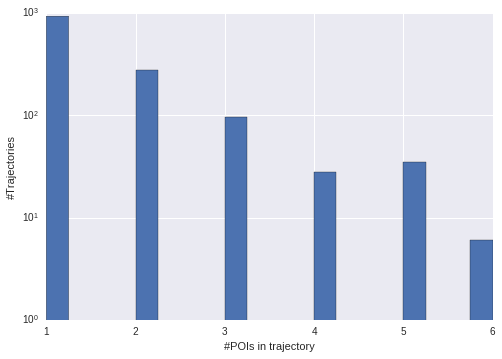

In [20]:
ax = traj_all['trajLen'].hist(bins=20)
ax.set_yscale('log')
ax.set_xlabel('#POIs in trajectory'); ax.set_ylabel('#Trajectories')

Distribution of POI visit duration.

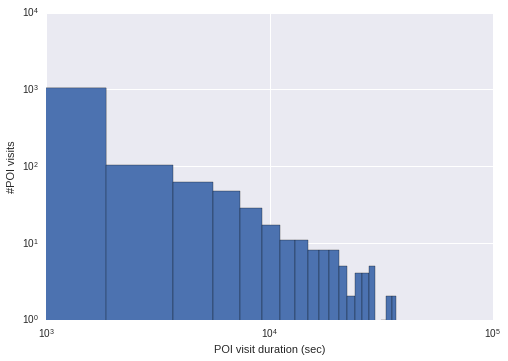

In [21]:
ax = traj_all['poiDuration'].hist(bins=20)
#ax.set_xlim(left=0.1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('POI visit duration (sec)'); ax.set_ylabel('#POI visits')

## 1.2 Utility Functions

Print computing progress.

In [22]:
def print_progress(cnt, total):
    """Display a progress bar"""
    assert(cnt > 0 and total > 0 and cnt <= total)
    length = 80
    ratio = cnt / total
    n = int(length * ratio)
    sys.stdout.write('\r[%-80s] %d%%' % ('-'*n, int(ratio*100)))
    sys.stdout.flush()

Extract trajectory, i.e., a list of POIs.

In [23]:
def extract_traj(tid, traj_all):
    traj = traj_all[traj_all['trajID'] == tid].copy()
    traj.sort_values(by=['startTime'], ascending=True, inplace=True)
    return traj['poiID'].tolist()

Compute POI properties, e.g., popularity, total number of visit, average visit duration.

In [24]:
def calc_poi_info(trajid_list, traj_all, poi_all):
    assert(len(trajid_list) > 0)
    poi_info = traj_all[traj_all['trajID'] == trajid_list[0]][['poiID', 'poiDuration']].copy() 
    for i in range(1, len(trajid_list)):
        traj = traj_all[traj_all['trajID'] == trajid_list[i]][['poiID', 'poiDuration']]
        poi_info = poi_info.append(traj, ignore_index=True)
    
    poi_info = poi_info.groupby('poiID').agg([np.mean, np.size])
    poi_info.columns = poi_info.columns.droplevel()
    poi_info.reset_index(inplace=True)
    poi_info.rename(columns={'mean':'avgDuration', 'size':'nVisit'}, inplace=True)
    poi_info.set_index('poiID', inplace=True) 
    poi_info['poiCat'] = poi_all.loc[poi_info.index, 'poiCat']
    poi_info['poiLon'] = poi_all.loc[poi_info.index, 'poiLon']
    poi_info['poiLat'] = poi_all.loc[poi_info.index, 'poiLat']
    
    # POI popularity: the number of distinct users that visited the POI
    pop_df = traj_all[traj_all['trajID'].isin(trajid_list)][['poiID', 'userID']].copy()
    pop_df = pop_df.groupby('poiID').agg(pd.Series.nunique)
    pop_df.rename(columns={'userID':'nunique'}, inplace=True)
    poi_info['popularity'] = pop_df.loc[poi_info.index, 'nunique']
    
    return poi_info.copy()

Compute the F1 score for recommended trajectory.

In [25]:
def calc_F1(traj_act, traj_rec, noloop=False):
    '''Compute recall, precision and F1 for recommended trajectories'''
    assert(isinstance(noloop, bool))
    assert(len(traj_act) > 0)
    assert(len(traj_rec) > 0)
    
    if noloop == True:
        intersize = len(set(traj_act) & set(traj_rec))
    else:
        match_tags = np.zeros(len(traj_act), dtype=np.bool)
        for poi in traj_rec:
            for j in range(len(traj_act)):
                if match_tags[j] == False and poi == traj_act[j]:
                    match_tags[j] = True
                    break
        intersize = np.nonzero(match_tags)[0].shape[0]
        
    recall = intersize / len(traj_act)
    precision = intersize / len(traj_rec)
    F1 = 2 * precision * recall / (precision + recall)
    return F1

Compute distance between two POIs using [Haversine formula](http://en.wikipedia.org/wiki/Great-circle_distance).

In [26]:
def calc_dist_vec(longitudes1, latitudes1, longitudes2, latitudes2):
    """Calculate the distance (unit: km) between two places on earth, vectorised"""
    # convert degrees to radians
    lng1 = np.radians(longitudes1)
    lat1 = np.radians(latitudes1)
    lng2 = np.radians(longitudes2)
    lat2 = np.radians(latitudes2)
    radius = 6371.0088 # mean earth radius, en.wikipedia.org/wiki/Earth_radius#Mean_radius

    # The haversine formula, en.wikipedia.org/wiki/Great-circle_distance
    dlng = np.fabs(lng1 - lng2)
    dlat = np.fabs(lat1 - lat2)
    dist =  2 * radius * np.arcsin( np.sqrt( 
                (np.sin(0.5*dlat))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(0.5*dlng))**2 ))
    return dist

Distance between POIs.

In [27]:
POI_DISTMAT = pd.DataFrame(data=np.zeros((poi_all.shape[0], poi_all.shape[0]), dtype=np.float), \
                           index=poi_all.index, columns=poi_all.index)

In [28]:
for ix in poi_all.index:
    POI_DISTMAT.loc[ix] = calc_dist_vec(poi_all.loc[ix, 'poiLon'], \
                                        poi_all.loc[ix, 'poiLat'], \
                                        poi_all['poiLon'], \
                                        poi_all['poiLat'])

In [29]:
trajid_set_all = sorted(traj_all['trajID'].unique().tolist())

In [30]:
poi_info_all = calc_poi_info(trajid_set_all, traj_all, poi_all)

Filtering out POI visits with 0 duration.

In [31]:
zero_duration = poi_info_all[poi_info_all['avgDuration'] < 1]
zero_duration

,avgDuration,nVisit,poiCat,poiLon,poiLat,popularity
poiID,,,,,,
27,0.0,3,Entertainment,135.501092,34.657725,3
29,0.0,2,Entertainment,135.505838,34.644641,2


In [32]:
print(traj_all.shape)
traj_all = traj_all[traj_all['poiID'].isin(set(poi_info_all.index) - set(zero_duration.index))]
print(traj_all.shape)

(1372, 8)
(1367, 8)


Dictionary maps every trajectory ID to the actual trajectory.

In [33]:
traj_dict = dict()

In [34]:
for trajid in trajid_set_all:
    traj = extract_traj(trajid, traj_all)
    assert(trajid not in traj_dict)
    traj_dict[trajid] = traj

Define a *query* (in IR terminology) using tuple (start POI, end POI, #POI) ~~user ID.~~

In [35]:
QUERY_ID_DICT = dict()  # (start, end, length) --> qid

In [36]:
keys = [(traj_dict[x][0], traj_dict[x][-1], len(traj_dict[x])) \
        for x in sorted(traj_dict.keys()) if len(traj_dict[x]) > 2]
cnt = 0
for key in keys:
    if key not in QUERY_ID_DICT:   # (start, end, length) --> qid
        QUERY_ID_DICT[key] = cnt
        cnt += 1

In [37]:
print('#traj in total:', len(trajid_set_all))
print('#traj (length > 2):', traj_all[traj_all['trajLen'] > 2]['trajID'].unique().shape[0])
print('#query tuple:', len(QUERY_ID_DICT))

#traj in total: 1115
#traj (length > 2): 47
#query tuple: 43


# 2. POI Ranking

## 2.1 POI Features for Ranking

POI Features used for ranking, given query (`startPOI`, `endPOI`, `nPOI`):
1. `category`: one-hot encoding of POI category, encode `True` as `1` and `False` as `-1`
1. `neighbourhood`: one-hot encoding of POI cluster, encode `True` as `1` and `False` as `-1`
1. `popularity`: log of POI popularity, i.e., the number of distinct users that visited the POI
1. `nVisit`: log of the total number of visit by all users
1. `avgDuration`: log of average POI visit duration
1. `trajLen`: trajectory length, i.e., the number of POIs `nPOI` in trajectory, copy from query
1. `sameCatStart`: 1 if POI category is the same as that of `startPOI`, -1 otherwise
1. `sameCatEnd`: 1 if POI category is the same as that of `endPOI`, -1 otherwise
1. `distStart`: distance (haversine formula) from `startPOI`
1. `distEnd`: distance from `endPOI`
1. `diffPopStart`: difference in POI popularity from `startPOI` (NO LOG as it could be negative)
1. `diffPopEnd`: difference in POI popularity from `endPOI`
1. `diffNVisitStart`: difference in the total number of visit from `startPOI`
1. `diffNVisitEnd`: difference in the total number of visit from `endPOI`
1. `diffDurationStart`: difference in average POI visit duration from the actual duration spent at `startPOI`
1. `diffDurationEnd`: difference in average POI visit duration from the actual duration spent at `endPOI`
1. `sameNeighbourhoodStart`: 1 if POI resides in the same cluster as that of `startPOI`, -1 otherwise
1. `sameNeighbourhoodEnd`: 1 if POI resides in the same cluster as that of `endPOI`, -1 otherwise

In [38]:
DF_COLUMNS = ['poiID', 'label', 'queryID', 'category', 'neighbourhood', 'popularity', 'nVisit', 'avgDuration', \
              'trajLen', 'sameCatStart', 'sameCatEnd', 'distStart', 'distEnd', 'diffPopStart', 'diffPopEnd', \
              'diffNVisitStart', 'diffNVisitEnd', 'diffDurationStart', 'diffDurationEnd', \
              'sameNeighbourhoodStart', 'sameNeighbourhoodEnd']

## 2.2 Training DataFrame

Training data are generated as follows:
1. each input tuple $(\text{startPOI}, \text{endPOI}, \text{#POI})$ form a `query` (in IR terminology).
1. the label of a specific POI is the number of presence of that POI in a specific `query`, excluding the presence as $\text{startPOI}$ or $\text{endPOI}$.
1. for each `query`, the label of all absence POIs from trajectories of that `query` in training set got a label 0.

The dimension of training data matrix is `#(qid, poi)` by `#feature`.

In [39]:
def gen_train_subdf(poi_id, query_id_set, poi_info, poi_clusters, cats, clusters, query_id_rdict):
    assert(isinstance(cats, list))
    assert(isinstance(clusters, list))
    
    columns = DF_COLUMNS
    poi_distmat = POI_DISTMAT
    df_ = pd.DataFrame(index=np.arange(len(query_id_set)), columns=columns)
    
    pop, nvisit = poi_info.loc[poi_id, 'popularity'], poi_info.loc[poi_id, 'nVisit']
    cat, cluster = poi_info.loc[poi_id, 'poiCat'], poi_clusters.loc[poi_id, 'clusterID'] 
    duration = poi_info.loc[poi_id, 'avgDuration']
    
    for j in range(len(query_id_set)):
        qid = query_id_set[j]
        assert(qid in query_id_rdict) # qid --> (start, end, length)
        (p0, pN, trajLen) = query_id_rdict[qid]
        idx = df_.index[j]
        df_.loc[idx, 'poiID'] = poi_id
        df_.loc[idx, 'queryID'] = qid
        df_.set_value(idx, 'category', tuple((cat == np.array(cats)).astype(np.int) * 2 - 1))
        df_.set_value(idx, 'neighbourhood', tuple((cluster == np.array(clusters)).astype(np.int) * 2 - 1))
        df_.loc[idx, 'popularity'] = LOG_SMALL if pop < 1 else np.log10(pop)
        df_.loc[idx, 'nVisit'] = LOG_SMALL if nvisit < 1 else np.log10(nvisit)
        df_.loc[idx, 'avgDuration'] = LOG_SMALL if duration < 1 else np.log10(duration)
        df_.loc[idx, 'trajLen'] = trajLen
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_info.loc[p0, 'poiCat'] else -1
        df_.loc[idx, 'sameCatEnd']   = 1 if cat == poi_info.loc[pN, 'poiCat'] else -1
        df_.loc[idx, 'distStart'] = poi_distmat.loc[poi_id, p0]
        df_.loc[idx, 'distEnd']   = poi_distmat.loc[poi_id, pN]
        df_.loc[idx, 'diffPopStart'] = pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffPopEnd']   = pop - poi_info.loc[pN, 'popularity']
        df_.loc[idx, 'diffNVisitStart'] = nvisit - poi_info.loc[p0, 'nVisit']
        df_.loc[idx, 'diffNVisitEnd']   = nvisit - poi_info.loc[pN, 'nVisit']
        df_.loc[idx, 'diffDurationStart'] = duration - poi_info.loc[p0, 'avgDuration']
        df_.loc[idx, 'diffDurationEnd']   = duration - poi_info.loc[pN, 'avgDuration']
        df_.loc[idx, 'sameNeighbourhoodStart'] = 1 if cluster == poi_clusters.loc[p0, 'clusterID'] else -1
        df_.loc[idx, 'sameNeighbourhoodEnd']   = 1 if cluster == poi_clusters.loc[pN, 'clusterID'] else -1
        
    return df_

In [40]:
def gen_train_df(trajid_list, traj_dict, poi_info, poi_clusters, cats, clusters, n_jobs=-1):    
    columns = DF_COLUMNS
    poi_distmat = POI_DISTMAT
    query_id_dict = QUERY_ID_DICT
    train_trajs = [traj_dict[x] for x in trajid_list if len(traj_dict[x]) > 2]
    
    qid_set = sorted(set([query_id_dict[(t[0], t[-1], len(t))] for t in train_trajs]))
    poi_set = set()
    for tr in train_trajs:
        poi_set = poi_set | set(tr)
    
    #qid_poi_pair = list(itertools.product(qid_set, poi_set)) # Cartesian product of qid_set and poi_set
    #df_ = pd.DataFrame(data=np.zeros((len(qid_poi_pair), len(columns)), dtype= np.float), columns=columns)
    
    query_id_rdict = dict()
    for k, v in query_id_dict.items(): 
        query_id_rdict[v] = k  # qid --> (start, end, length)
    
    train_df_list = Parallel(n_jobs=n_jobs)\
                            (delayed(gen_train_subdf)(poi, qid_set, poi_info, poi_clusters,cats,clusters,query_id_rdict) 
                             for poi in poi_set)
                        
    assert(len(train_df_list) > 0)
    df_ = train_df_list[0]
    for j in range(1, len(train_df_list)):
        df_ = df_.append(train_df_list[j], ignore_index=True)            
        
    # set label
    df_.set_index(['queryID', 'poiID'], inplace=True)
    df_['label'] = 0
    for t in train_trajs:
        qid = query_id_dict[(t[0], t[-1], len(t))]
        for poi in t[1:-1]:  # do NOT count if the POI is startPOI/endPOI
            df_.loc[(qid, poi), 'label'] += 1

    df_.reset_index(inplace=True)
    return df_

Sanity check: 
- different POIs have different features for the same query trajectory
- the same POI get different features for different query-id

## 2.3 Test DataFrame

Test data are generated the same way as training data, except that the labels of testing data (unknown) could be arbitrary values as suggested in [libsvm FAQ](http://www.csie.ntu.edu.tw/~cjlin/libsvm/faq.html#f431).
The reported accuracy (by `svm-predict` command) is meaningless as it is calculated based on these labels.

The dimension of training data matrix is `#poi` by `#feature` with one specific `query`, i.e. tuple $(\text{startPOI}, \text{endPOI}, \text{#POI})$.

In [41]:
def gen_test_df(startPOI, endPOI, nPOI, poi_info, poi_clusters, cats, clusters):
    assert(isinstance(cats, list))
    assert(isinstance(clusters, list))
    
    columns = DF_COLUMNS
    poi_distmat = POI_DISTMAT
    query_id_dict = QUERY_ID_DICT
    key = (p0, pN, trajLen) = (startPOI, endPOI, nPOI)
    assert(key in query_id_dict)
    assert(p0 in poi_info.index)
    assert(pN in poi_info.index)
    
    df_ = pd.DataFrame(index=np.arange(poi_info.shape[0]), columns=columns)
    poi_list = sorted(poi_info.index)
    
    qid = query_id_dict[key]
    df_['queryID'] = qid
    df_['label'] = np.random.rand(df_.shape[0]) # label for test data is arbitrary according to libsvm FAQ

    for i in range(df_.index.shape[0]):
        poi = poi_list[i]
        lon, lat = poi_info.loc[poi, 'poiLon'], poi_info.loc[poi, 'poiLat']
        pop, nvisit = poi_info.loc[poi, 'popularity'], poi_info.loc[poi, 'nVisit']
        cat, cluster = poi_info.loc[poi, 'poiCat'], poi_clusters.loc[poi, 'clusterID']
        duration = poi_info.loc[poi, 'avgDuration']
        idx = df_.index[i]
        df_.loc[idx, 'poiID'] = poi
        df_.set_value(idx, 'category', tuple((cat == np.array(cats)).astype(np.int) * 2 - 1))
        df_.set_value(idx, 'neighbourhood', tuple((cluster == np.array(clusters)).astype(np.int) * 2 - 1))
        df_.loc[idx, 'popularity'] = LOG_SMALL if pop < 1 else np.log10(pop)
        df_.loc[idx, 'nVisit'] = LOG_SMALL if nvisit < 1 else np.log10(nvisit)
        df_.loc[idx, 'avgDuration'] = LOG_SMALL if duration < 1 else np.log10(duration)
        df_.loc[idx, 'trajLen'] = trajLen
        df_.loc[idx, 'sameCatStart'] = 1 if cat == poi_all.loc[p0, 'poiCat'] else -1
        df_.loc[idx, 'sameCatEnd']   = 1 if cat == poi_all.loc[pN, 'poiCat'] else -1
        df_.loc[idx, 'distStart'] = poi_distmat.loc[poi, p0]
        df_.loc[idx, 'distEnd']   = poi_distmat.loc[poi, pN]
        df_.loc[idx, 'diffPopStart'] = pop - poi_info.loc[p0, 'popularity']
        df_.loc[idx, 'diffPopEnd']   = pop - poi_info.loc[pN, 'popularity']
        df_.loc[idx, 'diffNVisitStart'] = nvisit - poi_info.loc[p0, 'nVisit']
        df_.loc[idx, 'diffNVisitEnd']   = nvisit - poi_info.loc[pN, 'nVisit']
        df_.loc[idx, 'diffDurationStart'] = duration - poi_info.loc[p0, 'avgDuration']
        df_.loc[idx, 'diffDurationEnd']   = duration - poi_info.loc[pN, 'avgDuration']
        df_.loc[idx, 'sameNeighbourhoodStart'] = 1 if cluster == poi_clusters.loc[p0, 'clusterID'] else -1
        df_.loc[idx, 'sameNeighbourhoodEnd']   = 1 if cluster == poi_clusters.loc[pN, 'clusterID'] else -1
        
    return df_

Sanity check: 
- different POIs have different features for the same query trajectory
- the same POI get different features for different query-id

Generate a string for a training/test data frame.

In [42]:
def gen_data_str(df_, df_columns=DF_COLUMNS):
    columns = df_columns[1:].copy()  # get rid of 'poiID'
    for col in columns:
        assert(col in df_.columns)
        
    lines = []
    for idx in df_.index:
        slist = [str(df_.loc[idx, 'label'])]
        slist.append(' qid:')
        slist.append(str(int(df_.loc[idx, 'queryID'])))
        fid = 1
        for j in range(3, len(columns)):
            values_ = df_.get_value(idx, columns[j])
            values_ = values_ if isinstance(values_, tuple) else [values_]
            for v in values_:
                slist.append(' ')
                slist.append(str(fid)); fid += 1
                slist.append(':')
                slist.append(str(v))
        slist.append('\n')
        lines.append(''.join(slist))
    return ''.join(lines)

## 2.4 Ranking POIs using rankSVM

RankSVM implementation in [libsvm.zip](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/libsvm-ranksvm-3.20.zip) or [liblinear.zip](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/liblinear-ranksvm-1.95.zip), please read `README.ranksvm` in the zip file for installation instructions.

Use [softmax function](https://en.wikipedia.org/wiki/Softmax_function) to convert ranking scores to a probability distribution.

In [43]:
def softmax(x):
    x1 = x.copy()
    x1 -= np.max(x1)  # numerically more stable, REF: http://cs231n.github.io/linear-classify/#softmax
    expx = np.exp(x1)
    return expx / np.sum(expx, axis=0) # column-wise sum

Below is a python wrapper of the `svm-train` or `train` and `svm-predict` or `predict` commands of rankSVM with ranking probabilities $P(p_i \lvert (p_s, p_e, len))$ computed using [softmax function](https://en.wikipedia.org/wiki/Softmax_function).

In [44]:
# python wrapper of rankSVM
class RankSVM:
    def __init__(self, bin_dir, useLinear=True, debug=False):
        dir_ = !echo $bin_dir  # deal with environmental variables in path
        assert(os.path.exists(dir_[0]))
        self.bin_dir = dir_[0]
        
        self.bin_train = 'svm-train'
        self.bin_predict = 'svm-predict'
        if useLinear:
            self.bin_train = 'train'
            self.bin_predict = 'predict'
        
        assert(isinstance(debug, bool))
        self.debug = debug
        
        # create named tmp files for model and feature scaling parameters
        self.fmodel = None
        self.fscale = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fmodel = fd.name
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fscale = fd.name
        
        if self.debug:
            print('model file:', self.fmodel)
            print('feature scaling parameter file:', self.fscale)
    
    
    def __del__(self):
        # remove tmp files
        if self.fmodel is not None and os.path.exists(self.fmodel):
            os.unlink(self.fmodel)
        if self.fscale is not None and os.path.exists(self.fscale):
            os.unlink(self.fscale)
    
    
    def train(self, train_df, cost=1):
        # cost is parameter C in SVM
        # write train data to file
        ftrain = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain = fd.name
            datastr = gen_data_str(train_df)
            fd.write(datastr)
        
        # feature scaling
        ftrain_scaled = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain_scaled = fd.name
        result = !$self.bin_dir/svm-scale -s $self.fscale $ftrain > $ftrain_scaled
        
        if self.debug:
            print('cost:', cost)
            print('train data file:', ftrain)
            print('feature scaled train data file:', ftrain_scaled)
        
        # train rank svm and generate model file, if the model file exists, rewrite it
        #n_cv = 10  # parameter k for k-fold cross-validation, NO model file will be generated in CV mode
        #result = !$self.bin_dir/svm-train -c $cost -v $n_cv $ftrain $self.fmodel
        result = !$self.bin_dir/$self.bin_train -c $cost $ftrain_scaled $self.fmodel
        if self.debug:
            print('Training finished.')
            for i in range(len(result)): print(result[i])

        # remove train data file
        os.unlink(ftrain)
        os.unlink(ftrain_scaled)        
        
    
    def predict(self, test_df):
        # predict ranking scores for the given feature matrix
        if self.fmodel is None or not os.path.exists(self.fmodel):
            print('Model should be trained before predicting')
            return
        
        # write test data to file
        ftest = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftest = fd.name
            datastr = gen_data_str(test_df)
            fd.write(datastr)
                
        # feature scaling
        ftest_scaled = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            ftest_scaled = fd.name
        result = !$self.bin_dir/svm-scale -r $self.fscale $ftest > $ftest_scaled
            
        # generate prediction file
        fpredict = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            fpredict = fd.name
            
        if self.debug:
            print('test data file:', ftest)
            print('feature scaled test data file:', ftest_scaled)
            print('predict result file:', fpredict)
            
        # predict using trained model and write prediction to file
        result = !$self.bin_dir/$self.bin_predict $ftest_scaled $self.fmodel $fpredict
        if self.debug:
            print('Predict result: %-30s  %s' % (result[0], result[1]))
        
        # generate prediction DataFrame from prediction file
        poi_rank_df = pd.read_csv(fpredict, header=None)
        poi_rank_df.rename(columns={0:'rank'}, inplace=True)
        poi_rank_df['poiID'] = test_df['poiID'].astype(np.int)
        poi_rank_df.set_index('poiID', inplace=True) # duplicated 'poiID' when evaluating training data
        poi_rank_df['probability'] = softmax(poi_rank_df['rank'])  # softmax
        
        # remove test file and prediction file
        os.unlink(ftest)
        os.unlink(ftest_scaled)
        os.unlink(fpredict)
        
        return poi_rank_df

# 3. Factorised Transition Probabilities between POIs

Estimate a transition matrix for each feature of POI, transition probabilities between different POIs are obtrained by the Kronecker product of the individual transition matrix corresponding to each feature (with normalisation and a few constraints).

## 3.1 POI Features for Factorisation

POI features used to factorise transition matrix of Markov Chain with POI features (vector) as states:
- Category of POI
- Popularity of POI (discritize with uniform log-scale bins, #bins <=5 )
- The number of POI visits (discritize with uniform log-scale bins, #bins <=5 )
- The average visit duration of POI (discritise with uniform log-scale bins, #bins <= 5)
- The neighborhood relationship between POIs (clustering POI(lat, lon) using k-means, #clusters <= 5)

We count the number of transition first, then normalise each row while taking care of zero by adding each cell a number $k=1$.

In [45]:
def normalise_transmat(transmat_cnt):
    transmat = transmat_cnt.copy()
    assert(isinstance(transmat, pd.DataFrame))
    for row in range(transmat.index.shape[0]):
        rowsum = np.sum(transmat.iloc[row] + 1)
        assert(rowsum > 0)
        transmat.iloc[row] = (transmat.iloc[row] + 1) / rowsum
    return transmat

POIs in training set.

In [46]:
poi_train = sorted(poi_info_all.index)

## 3.2 Transition Matrix between POI Cateogries

In [47]:
poi_cats = poi_all.loc[poi_train, 'poiCat'].unique().tolist()
poi_cats.sort()
POI_CAT_LIST = poi_cats
POI_CAT_LIST

['Amusement', 'Entertainment', 'Historical', 'Park']

In [48]:
def gen_transmat_cat(trajid_list, traj_dict, poi_info, poi_cats=POI_CAT_LIST):
    transmat_cat_cnt = pd.DataFrame(data=np.zeros((len(poi_cats), len(poi_cats)), dtype=np.float), \
                                    columns=poi_cats, index=poi_cats)
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                cat1 = poi_info.loc[p1, 'poiCat']
                cat2 = poi_info.loc[p2, 'poiCat']
                transmat_cat_cnt.loc[cat1, cat2] += 1
    return normalise_transmat(transmat_cat_cnt)

In [49]:
gen_transmat_cat(trajid_set_all, traj_dict, poi_info_all)

,Amusement,Entertainment,Historical,Park
Amusement,0.576923,0.256410,0.012821,0.153846
Entertainment,0.247788,0.548673,0.053097,0.150442
Historical,0.166667,0.375000,0.125000,0.333333
Park,0.410714,0.392857,0.089286,0.107143


## 3.3 Transition Matrix between POI Popularity Classes

In [50]:
poi_pops = poi_info_all.loc[poi_train, 'popularity']
#sorted(poi_pops.unique().tolist())

Discretize POI popularity with uniform log-scale bins.

In [51]:
expo_pop1 = np.log10(max(1, min(poi_pops)))
expo_pop2 = np.log10(max(poi_pops))
print(expo_pop1, expo_pop2)

0.0 2.10720996965


In [52]:
nbins_pop = BIN_CLUSTER
logbins_pop = np.logspace(np.floor(expo_pop1), np.ceil(expo_pop2), nbins_pop+1)
logbins_pop[0] = 0  # deal with underflow
if uspecific == True:
    logbins_pop[-1] = KX * logbins_pop[-1]  # deal with overflow
if logbins_pop[-1] < poi_info_all['popularity'].max():
    logbins_pop[-1] = poi_info_all['popularity'].max() + 1
logbins_pop

array([    0.        ,     3.98107171,    15.84893192,    63.09573445,
         251.18864315,  1000.        ])

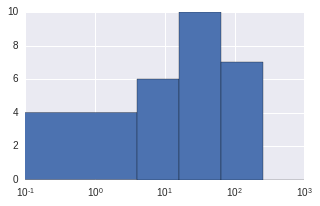

In [53]:
ax = pd.Series(poi_pops).hist(figsize=(5, 3), bins=logbins_pop)
ax.set_xlim(xmin=0.1)
ax.set_xscale('log')

In [54]:
def gen_transmat_pop(trajid_list, traj_dict, poi_info, logbins_pop=logbins_pop):
    nbins = len(logbins_pop) - 1
    transmat_pop_cnt = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                    columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                pop1 = poi_info.loc[p1, 'popularity']
                pop2 = poi_info.loc[p2, 'popularity']
                pc1, pc2 = np.digitize([pop1, pop2], logbins_pop)
                transmat_pop_cnt.loc[pc1, pc2] += 1
    return normalise_transmat(transmat_pop_cnt), logbins_pop

In [55]:
gen_transmat_pop(trajid_set_all, traj_dict, poi_info_all)[0]

,1,2,3,4,5
1,0.166667,0.166667,0.166667,0.333333,0.166667
2,0.080000,0.040000,0.480000,0.360000,0.040000
3,0.009901,0.069307,0.326733,0.584158,0.009901
4,0.013986,0.034965,0.356643,0.587413,0.006993
5,0.200000,0.200000,0.200000,0.200000,0.200000


## 3.4 Transition Matrix between the Number of POI Visit Classes

In [56]:
poi_visits = poi_info_all.loc[poi_train, 'nVisit']
#sorted(poi_visits.unique().tolist())

Discretize the number of POI visit with uniform log-scale bins.

In [57]:
expo_visit1 = np.log10(max(1, min(poi_visits)))
expo_visit2 = np.log10(max(poi_visits))
print(expo_visit1, expo_visit2)

0.0 2.16435285578


In [58]:
nbins_visit = BIN_CLUSTER
logbins_visit = np.logspace(np.floor(expo_visit1), np.ceil(expo_visit2), nbins_visit+1)
logbins_visit[0] = 0  # deal with underflow
if uspecific == True:
    logbins_visit[-1] = KX * logbins_visit[-1]  # deal with overflow
if logbins_visit[-1] < poi_info_all['nVisit'].max():
    logbins_visit[-1] = poi_info_all['nVisit'].max() + 1
logbins_visit

array([    0.        ,     3.98107171,    15.84893192,    63.09573445,
         251.18864315,  1000.        ])

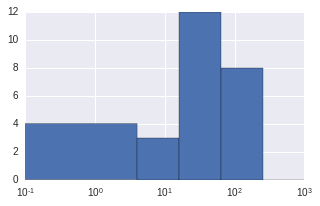

In [59]:
ax = pd.Series(poi_visits).hist(figsize=(5, 3), bins=logbins_visit)
ax.set_xlim(xmin=0.1)
ax.set_xscale('log')

In [60]:
def gen_transmat_visit(trajid_list, traj_dict, poi_info, logbins_visit=logbins_visit):
    nbins = len(logbins_visit) - 1
    transmat_visit_cnt = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                      columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                visit1 = poi_info.loc[p1, 'nVisit']
                visit2 = poi_info.loc[p2, 'nVisit']
                vc1, vc2 = np.digitize([visit1, visit2], logbins_visit)
                transmat_visit_cnt.loc[vc1, vc2] += 1
    return normalise_transmat(transmat_visit_cnt), logbins_visit

In [61]:
gen_transmat_visit(trajid_set_all, traj_dict, poi_info_all)[0]

,1,2,3,4,5
1,0.166667,0.166667,0.166667,0.333333,0.166667
2,0.111111,0.111111,0.333333,0.333333,0.111111
3,0.021739,0.021739,0.250000,0.695652,0.010870
4,0.011905,0.017857,0.327381,0.636905,0.005952
5,0.200000,0.200000,0.200000,0.200000,0.200000


## 3.5 Transition Matrix between POI Average Visit Duration Classes

In [62]:
poi_durations = poi_info_all.loc[poi_train, 'avgDuration']
#sorted(poi_durations.unique().tolist())

In [63]:
expo_duration1 = np.log10(max(1, min(poi_durations)))
expo_duration2 = np.log10(max(poi_durations))
print(expo_duration1, expo_duration2)

0.0 3.91522170101


In [64]:
nbins_duration = BIN_CLUSTER
logbins_duration = np.logspace(np.floor(expo_duration1), np.ceil(expo_duration2), nbins_duration+1)
logbins_duration[0] = 0  # deal with underflow
if uspecific == True:
    logbins_duration[-1] = KX * logbins_duration[-1]  # deal with overflow
else:
    logbins_duration[-1] = np.power(10, expo_duration2+2)
logbins_duration

array([  0.00000000e+00,   6.30957344e+00,   3.98107171e+01,
         2.51188643e+02,   1.58489319e+03,   8.22662500e+05])

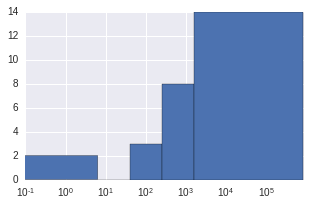

In [65]:
ax = pd.Series(poi_durations).hist(figsize=(5, 3), bins=logbins_duration)
ax.set_xlim(xmin=0.1)
ax.set_xscale('log')

In [66]:
def gen_transmat_duration(trajid_list, traj_dict, poi_info, logbins_duration=logbins_duration):
    nbins = len(logbins_duration) - 1
    transmat_duration_cnt = pd.DataFrame(data=np.zeros((nbins, nbins), dtype=np.float), \
                                         columns=np.arange(1, nbins+1), index=np.arange(1, nbins+1))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                d1 = poi_info.loc[p1, 'avgDuration']
                d2 = poi_info.loc[p2, 'avgDuration']
                dc1, dc2 = np.digitize([d1, d2], logbins_duration)
                transmat_duration_cnt.loc[dc1, dc2] += 1
    return normalise_transmat(transmat_duration_cnt), logbins_duration

In [67]:
gen_transmat_duration(trajid_set_all, traj_dict, poi_info_all)[0]

,1,2,3,4,5
1,0.200000,0.200000,0.200000,0.200000,0.200000
2,0.200000,0.200000,0.200000,0.200000,0.200000
3,0.166667,0.166667,0.166667,0.166667,0.333333
4,0.014085,0.014085,0.014085,0.239437,0.718310
5,0.005181,0.005181,0.020725,0.233161,0.735751


## 3.6 Transition Matrix between POI Neighborhood Classes

KMeans in scikit-learn seems unable to use custom distance metric and no implementation of [Haversine formula](http://en.wikipedia.org/wiki/Great-circle_distance), use Euclidean distance to approximate.

In [68]:
X = poi_all.loc[poi_train, ['poiLon', 'poiLat']]
nclusters = BIN_CLUSTER

In [69]:
kmeans = KMeans(n_clusters=nclusters, random_state=987654321)
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=987654321,
    tol=0.0001, verbose=0)

In [70]:
clusters = kmeans.predict(X)
POI_CLUSTER_LIST = sorted(np.unique(clusters))
#clusters
POI_CLUSTERS = pd.DataFrame(data=clusters, index=poi_train)
POI_CLUSTERS.index.name = 'poiID'
POI_CLUSTERS.rename(columns={0:'clusterID'}, inplace=True)
POI_CLUSTERS['clusterID'] = POI_CLUSTERS['clusterID'].astype(np.int)
#POI_CLUSTERS

Scatter plot of POI coordinates with clustering results.

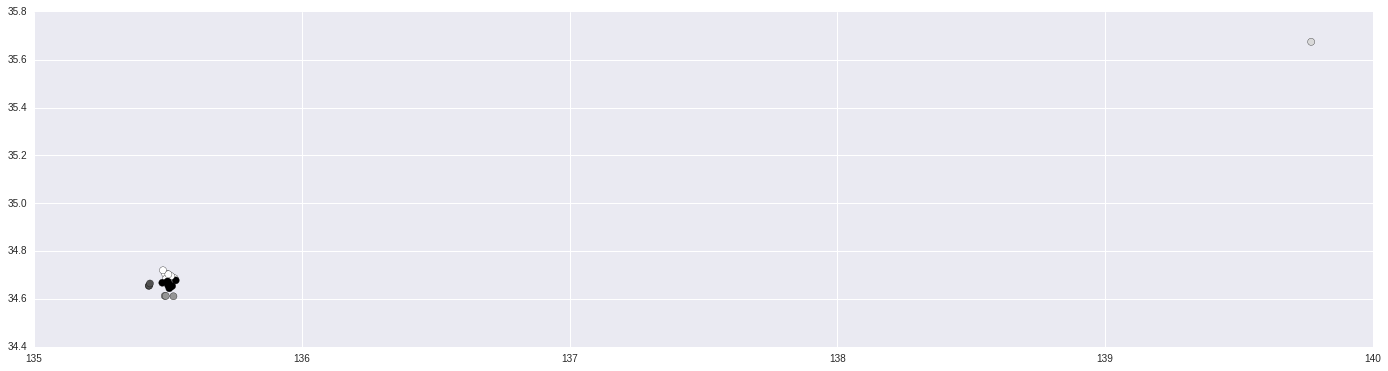

In [71]:
diff = poi_all.loc[poi_train, ['poiLon', 'poiLat']].max() - poi_all.loc[poi_train, ['poiLon', 'poiLat']].min()
ratio = diff['poiLon'] / diff['poiLat']
#ratio
height = 6; width = int(round(ratio)*height)
plt.figure(figsize=[width, height])
plt.scatter(poi_all.loc[poi_train, 'poiLon'], poi_all.loc[poi_train, 'poiLat'], c=clusters, s=50)

In [72]:
#poi_df_plot = poi_info_all.copy()
#poi_df_plot['clusterID'] = POI_CLUSTERS.loc[poi_df_plot.index, 'clusterID'].astype(np.int)

In [73]:
#poi_df_plot.head()

In [74]:
#poi_df_plot.to_csv('poi_df_plot.csv', index=True)

In [75]:
def gen_transmat_neighbor(trajid_list, traj_dict, poi_info, poi_clusters=POI_CLUSTERS):
    nclusters = len(poi_clusters['clusterID'].unique())
    transmat_neighbor_cnt = pd.DataFrame(data=np.zeros((nclusters, nclusters), dtype=np.float), \
                                         columns=np.arange(nclusters), index=np.arange(nclusters))
    for tid in trajid_list:
        t = traj_dict[tid]
        if len(t) > 1:
            for pi in range(len(t)-1):
                p1 = t[pi]
                p2 = t[pi+1]
                assert(p1 in poi_info.index and p2 in poi_info.index)
                c1 = poi_clusters.loc[p1, 'clusterID']
                c2 = poi_clusters.loc[p2, 'clusterID']
                transmat_neighbor_cnt.loc[c1, c2] += 1
    return normalise_transmat(transmat_neighbor_cnt), poi_clusters

In [76]:
gen_transmat_neighbor(trajid_set_all, traj_dict, poi_info_all)[0]

,0,1,2,3,4
0,0.440476,0.011905,0.023810,0.119048,0.404762
1,0.200000,0.200000,0.200000,0.200000,0.200000
2,0.222222,0.111111,0.111111,0.222222,0.333333
3,0.226415,0.018868,0.018868,0.641509,0.094340
4,0.294574,0.007752,0.023256,0.015504,0.658915


## 3.7 Visualise Transition Matrices for Individual Features

Visualise Transition matrices for Melbourne dataset.

In [77]:
do_plot = False
if dat_suffix[dat_ix] == 'Melb':
    do_plot = True

In [78]:
if do_plot == True:
    mats = [gen_transmat_cat(trajid_set_all, traj_dict, poi_info_all),
            gen_transmat_pop(trajid_set_all, traj_dict, poi_info_all)[0],
            gen_transmat_visit(trajid_set_all, traj_dict, poi_info_all)[0],
            gen_transmat_duration(trajid_set_all, traj_dict, poi_info_all)[0],
            gen_transmat_neighbor(trajid_set_all, traj_dict, poi_info_all)[0]]
    names = ['POI Categories', 'POI Popularity', '#Visits at POI', 'POI Visit Duration', 'POI Neighborhood']
    svgnames = ['transmat_cat.svg','transmat_pop.svg','transmat_nvisit.svg','transmat_duration.svg',\
                'transmat_cluster.svg']

Rename some categories for plotting on Melbourne dataset.

In [79]:
if do_plot == True:
    print(mats[0].columns)
    print(mats[0].index)

In [80]:
if do_plot == True:
    cats_rename = ['City precincts', 'Entertainment', 'Institutions', 'Parks', 'Museums', 'Shopping', \
                   'Sports', 'Structures', 'Transport']
    mats0 = pd.DataFrame(data=mats[0].values, columns=cats_rename, index=cats_rename)
    mats[0] = mats0

Change the names of POI clusters. **NOTE: Need to check the names for clusters each time after running Kmeans**.

In [81]:
if do_plot == True:
    print(mats[1].index, mats[1].columns)
    print(mats[2].index, mats[2].columns)
    print(mats[3].index, mats[3].columns)
    print(mats[4].index, mats[4].columns)

In [82]:
# West:0
# North:1
# East-Central:2
# Northwest:3
# South:4
if do_plot == True:
    positions = ['West', 'North', 'East-Central', 'Northwest', 'South']
    mats4 = pd.DataFrame(data=mats[4].values, columns=positions, index=positions)
    mats[4] = mats4

In [83]:
if do_plot == True:
    max([np.amax(mats[1].values), np.amax(mats[2].values), np.amax(mats[3].values), np.amax(mats[4].values)])

In [84]:
if do_plot == True:
    #cmap_ = plt.cm.hot
    #cmap_ = plt.cm.hot_r
    #cmap_ = plt.cm.jet
    #cmap_ = plt.cm.jet_r
    #cmap_ = plt.cm.inferno
    #cmap_ = plt.cm.inferno_r
    #cmap_ = plt.cm.coolwarm
    cmap_ = plt.cm.BuGn

    fig = plt.figure(figsize=[4, 3])
    ix = 0
    cbar = True if ix in [0, 3] else False
    labels=['Least', '', '$\\longrightarrow$', '', 'Most'] if ix in [1, 2, 3] else True
    vmin = None if ix == 0 else 0
    vmax = None if ix == 0 else 0.871
    snsplt = sns.heatmap(mats[ix], cmap=cmap_, xticklabels=labels, yticklabels=labels, cbar=cbar, square=True)
    snsplt.set_title(names[ix])
    snsplt.get_figure().savefig(svgnames[ix], dpi=150)

## 3.8 Transition Matrix between POIs

Approximate transition probabilities (matrix) between different POI features (vector) using the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) of individual transition matrix corresponding to each feature, i.e., POI category, POI popularity (discritized), POI average visit duration (discritized) and POI neighborhoods (clusters).

Deal with features without corresponding POIs and feature with more than one corresponding POIs. (*Before Normalisation*)
- For features without corresponding POIs, just remove the rows and columns from the matrix obtained by Kronecker product.
- For different POIs with the exact same feature, 
  - Let POIs with the same feature as a POI group,
  - The *incoming* **transition value (i.e., unnormalised transition probability)** of this POI group 
    should be divided uniformly among the group members, 
    *which corresponds to choose a group member uniformly at random in the incoming case*.
  - The *outgoing* transition value should be duplicated (i.e., the same) among all group members, 
    **as we were already in that group in the outgoing case**.
  - For each POI in the group, the allocation transition value of the *self-loop of the POI group* is similar to 
    that in the *outgoing* case, **as we were already in that group**, so just duplicate and then divide uniformly among 
    the transitions from this POI to other POIs in the same group, 
    *which corresponds to choose a outgoing transition uniformly at random from all outgoing transitions
    excluding the self-loop of this POI*.
- **Concretely**, for a POI group with $n$ POIs, 
    1. If the *incoming* transition value of POI group is $m_1$,
       then the corresponding *incoming* transition value for each group member is $\frac{m_1}{n}$.
    1. If the *outgoing* transition value of POI group is $m_2$,
       then the corresponding *outgoing* transition value for each group member is also $m_2$.
    1. If the transition value of *self-loop of the POI group* is $m_3$,
       then transition value of *self-loop of individual POIs* should be $0$,  
       and *other in-group transitions* with value $\frac{m_3}{n-1}$
       as the total number of outgoing transitions to other POIs in the same group is $n-1$ (excluding the self-loop),
       i.e. $n-1$ choose $1$.
       
**NOTE**: execute the above division before or after row normalisation will lead to the same result, *as the division itself does NOT change the normalising constant of each row (i.e., the sum of each row before normalising)*.

In [85]:
def gen_poi_logtransmat(trajid_list, poi_set, traj_dict, poi_info, debug=False):
    transmat_cat                        = gen_transmat_cat(trajid_list, traj_dict, poi_info)
    transmat_pop,      logbins_pop      = gen_transmat_pop(trajid_list, traj_dict, poi_info)
    transmat_visit,    logbins_visit    = gen_transmat_visit(trajid_list, traj_dict, poi_info)
    transmat_duration, logbins_duration = gen_transmat_duration(trajid_list, traj_dict, poi_info)
    transmat_neighbor, poi_clusters     = gen_transmat_neighbor(trajid_list, traj_dict, poi_info)

    # Kronecker product
    transmat_ix = list(itertools.product(transmat_cat.index, transmat_pop.index, transmat_visit.index, \
                                         transmat_duration.index, transmat_neighbor.index))
    transmat_value = transmat_cat.values
    for transmat in [transmat_pop, transmat_visit, transmat_duration, transmat_neighbor]:
        transmat_value = kron(transmat_value, transmat.values)
    transmat_feature = pd.DataFrame(data=transmat_value, index=transmat_ix, columns=transmat_ix)
    
    poi_train = sorted(poi_set)
    feature_names = ['poiCat', 'popularity', 'nVisit', 'avgDuration', 'clusterID']
    poi_features = pd.DataFrame(data=np.zeros((len(poi_train), len(feature_names))), \
                                columns=feature_names, index=poi_train)
    poi_features.index.name = 'poiID'
    poi_features['poiCat'] = poi_info.loc[poi_train, 'poiCat']
    poi_features['popularity'] = np.digitize(poi_info.loc[poi_train, 'popularity'], logbins_pop)
    poi_features['nVisit'] = np.digitize(poi_info.loc[poi_train, 'nVisit'], logbins_visit)
    poi_features['avgDuration'] = np.digitize(poi_info.loc[poi_train, 'avgDuration'], logbins_duration)
    poi_features['clusterID'] = poi_clusters.loc[poi_train, 'clusterID']
    
    # shrink the result of Kronecker product and deal with POIs with the same features
    poi_logtransmat = pd.DataFrame(data=np.zeros((len(poi_train), len(poi_train)), dtype=np.float), \
                                   columns=poi_train, index=poi_train)
    for p1 in poi_logtransmat.index:
        rix = tuple(poi_features.loc[p1])
        for p2 in poi_logtransmat.columns:
            cix = tuple(poi_features.loc[p2])
            value_ = transmat_feature.loc[(rix,), (cix,)]
            poi_logtransmat.loc[p1, p2] = value_.values[0, 0]
    
    # group POIs with the same features
    features_dup = dict()
    for poi in poi_features.index:
        key = tuple(poi_features.loc[poi])
        if key in features_dup:
            features_dup[key].append(poi)
        else:
            features_dup[key] = [poi]
    if debug == True:
        for key in sorted(features_dup.keys()):
            print(key, '->', features_dup[key])
            
    # deal with POIs with the same features
    for feature in sorted(features_dup.keys()):
        n = len(features_dup[feature])
        if n > 1:
            group = features_dup[feature]
            v1 = poi_logtransmat.loc[group[0], group[0]]  # transition value of self-loop of POI group
            
            # divide incoming transition value (i.e. unnormalised transition probability) uniformly among group members
            for poi in group:
                poi_logtransmat[poi] /= n
                
            # outgoing transition value has already been duplicated (value copied above)
            
            # duplicate & divide transition value of self-loop of POI group uniformly among all outgoing transitions,
            # from a POI to all other POIs in the same group (excluding POI self-loop)
            v2 = v1 / (n - 1)
            for pair in itertools.permutations(group, 2):
                poi_logtransmat.loc[pair[0], pair[1]] = v2
                            
    # normalise each row
    for p1 in poi_logtransmat.index:
        poi_logtransmat.loc[p1, p1] = 0
        rowsum = poi_logtransmat.loc[p1].sum()
        assert(rowsum > 0)
        logrowsum = np.log10(rowsum)
        for p2 in poi_logtransmat.columns:
            if p1 == p2:
                #poi_logtransmat.loc[p1, p2] = -np.inf  # deal with log(0) explicitly
                poi_logtransmat.loc[p1, p2] = LOG_ZERO
            else:
                poi_logtransmat.loc[p1, p2] = np.log10(poi_logtransmat.loc[p1, p2]) - logrowsum
    
    return poi_logtransmat

In [86]:
transmat_ = gen_poi_logtransmat(trajid_set_all, set(poi_info_all.index), traj_dict, poi_info_all, debug=True)

('Amusement', 3, 3, 4, 3) -> [2]
('Amusement', 3, 3, 5, 3) -> [4]
('Amusement', 3, 3, 5, 4) -> [3]
('Amusement', 4, 4, 4, 0) -> [5]
('Amusement', 4, 4, 5, 0) -> [6]
('Amusement', 4, 4, 5, 3) -> [1]
('Entertainment', 1, 1, 1, 4) -> [27, 29]
('Entertainment', 2, 2, 3, 4) -> [19]
('Entertainment', 2, 3, 4, 0) -> [25]
('Entertainment', 3, 3, 4, 0) -> [28]
('Entertainment', 3, 3, 4, 4) -> [23, 24]
('Entertainment', 3, 4, 5, 4) -> [22]
('Entertainment', 4, 4, 4, 1) -> [26]
('Entertainment', 4, 4, 5, 4) -> [20, 21]
('Historical', 1, 1, 3, 4) -> [17]
('Historical', 2, 2, 5, 2) -> [16]
('Historical', 3, 3, 5, 0) -> [18]
('Historical', 3, 3, 5, 4) -> [15]
('Park', 1, 1, 3, 2) -> [9]
('Park', 2, 2, 4, 2) -> [12]
('Park', 2, 3, 5, 0) -> [11]
('Park', 2, 3, 5, 4) -> [10]
('Park', 3, 3, 5, 0) -> [7]
('Park', 4, 4, 5, 0) -> [8]


## 3.9 Viterbi Decoding vs ILP

Use dynamic programming to find a possibly non-simple path, i.e., walk.   

Can include/exclude `startPOI` and `endPOI` when evaluating intermediate POIs in dynamic programming.

In [87]:
def find_path(V, E, ps, pe, L, withNodeWeight=False, alpha=0.5, withStartEndIntermediate=False):
    assert(isinstance(V, pd.DataFrame))
    assert(isinstance(E, pd.DataFrame))
    assert(ps in V.index)
    assert(pe in V.index)
    # with sub-tours in trajectory, this is not the case any more, but it is nonsense to recommend such trajectories
    assert(2 < L <= V.index.shape[0])  
    if withNodeWeight == True:
        assert(0 < alpha < 1)
        beta = 1 - alpha
    else:
        alpha = 0
        beta = 1
        weightkey = 'weight'
        if weightkey not in V.columns:
            V['weight'] = 1  # dummy weights, will not be used as alpha=0
    if withStartEndIntermediate == True:
        excludes = [ps]
    else:
        excludes = [ps, pe]
    
    A = pd.DataFrame(data=np.zeros((L-1, V.shape[0]), dtype=np.float), columns=V.index, index=np.arange(2, L+1))
    B = pd.DataFrame(data=np.zeros((L-1, V.shape[0]), dtype=np.int),   columns=V.index, index=np.arange(2, L+1))
    A += np.inf
    for v in V.index:            
        if v not in excludes:
            A.loc[2, v] = alpha * (V.loc[ps, 'weight'] + V.loc[v, 'weight']) + beta * E.loc[ps, v]  # ps--v
            B.loc[2, v] = ps
    
    for l in range(3, L+1):
        for v in V.index:
            if withStartEndIntermediate == True: # ps-~-v1---v 
                values = [A.loc[l-1, v1] + alpha * V.loc[v, 'weight'] + beta * E.loc[v1, v] for v1 in V.index]
            else: # ps-~-v1---v 
                values = [A.loc[l-1, v1] + alpha * V.loc[v, 'weight'] + beta * E.loc[v1, v] \
                          if v1 not in [ps, pe] else np.inf for v1 in V.index] # exclude ps and pe
            
            minix = np.argmin(values)
            A.loc[l, v] = values[minix]
            B.loc[l, v] = V.index[minix]
            
    path = [pe]
    v = path[-1]
    l = L
    #while v != ps:  #incorrect if 'ps' happens to appear in the middle of a path
    while l >= 2:
        path.append(B.loc[l, v])
        v = path[-1]
        l -= 1
    path.reverse()
    return path

Use integer linear programming (ILP) to find a simple path.

In [88]:
def find_path_ILP(V, E, ps, pe, L, withNodeWeight=False, alpha=0.5):
    assert(isinstance(V, pd.DataFrame))
    assert(isinstance(E, pd.DataFrame))
    assert(ps in V.index)
    assert(pe in V.index)
    assert(2 < L <= V.index.shape[0])
    if withNodeWeight == True:
        assert(0 < alpha < 1)
    beta = 1 - alpha
    
    p0 = str(ps); pN = str(pe); N = V.index.shape[0]
    
    # deal with np.inf which will cause ILP solver failure
    Edges = E.copy()
    INF = 1e6
    for p in Edges.index:
        Edges.loc[p, p] = INF 
    maxL = np.max(Edges.values.flatten())
    if maxL > INF:
        for p in Edges.index:
            Edges.loc[p, p] = maxL    
    
    # REF: pythonhosted.org/PuLP/index.html
    pois = [str(p) for p in V.index] # create a string list for each POI
    pb = pulp.LpProblem('MostLikelyTraj', pulp.LpMinimize) # create problem
    # visit_i_j = 1 means POI i and j are visited in sequence
    visit_vars = pulp.LpVariable.dicts('visit', (pois, pois), 0, 1, pulp.LpInteger) 
    # a dictionary contains all dummy variables
    dummy_vars = pulp.LpVariable.dicts('u', [x for x in pois if x != p0], 2, N, pulp.LpInteger)
    
    # add objective
    objlist = []
    if withNodeWeight == True:
        objlist.append(alpha * V.loc[int(p0), 'weight'])
    for pi in [x for x in pois if x != pN]:     # from
        for pj in [y for y in pois if y != p0]: # to
            if withNodeWeight == True:
                objlist.append(visit_vars[pi][pj] * (alpha*V.loc[int(pj), 'weight'] + beta*Edges.loc[int(pi), int(pj)]))
            else:
                objlist.append(visit_vars[pi][pj] * Edges.loc[int(pi), int(pj)])
    pb += pulp.lpSum(objlist), 'Objective'
    
    # add constraints, each constraint should be in ONE line
    pb += pulp.lpSum([visit_vars[p0][pj] for pj in pois if pj != p0]) == 1, 'StartAt_p0'
    pb += pulp.lpSum([visit_vars[pi][pN] for pi in pois if pi != pN]) == 1, 'EndAt_pN'
    if p0 != pN:
        pb += pulp.lpSum([visit_vars[pi][p0] for pi in pois]) == 0, 'NoIncoming_p0'
        pb += pulp.lpSum([visit_vars[pN][pj] for pj in pois]) == 0, 'NoOutgoing_pN'
    pb += pulp.lpSum([visit_vars[pi][pj] for pi in pois if pi != pN for pj in pois if pj != p0]) == L-1, 'Length'
    for pk in [x for x in pois if x not in {p0, pN}]:
        pb += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) == \
              pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]), 'ConnectedAt_' + pk
        pb += pulp.lpSum([visit_vars[pi][pk] for pi in pois if pi != pN]) <= 1, 'Enter_' + pk + '_AtMostOnce'
        pb += pulp.lpSum([visit_vars[pk][pj] for pj in pois if pj != p0]) <= 1, 'Leave_' + pk + '_AtMostOnce'
    for pi in [x for x in pois if x != p0]:
        for pj in [y for y in pois if y != p0]:
            pb += dummy_vars[pi] - dummy_vars[pj] + 1 <= (N - 1) * (1 - visit_vars[pi][pj]), \
                    'SubTourElimination_' + pi + '_' + pj
    #pb.writeLP("traj_tmp.lp")
    # solve problem
    pb.solve(pulp.PULP_CBC_CMD(options=['-threads', '6', '-strategy', '1', '-maxIt', '2000000'])) # CBC
    #gurobi_options = [('TimeLimit', '7200'), ('Threads', '8'), ('NodefileStart', '0.9'), ('Cuts', '2')]
    #pb.solve(pulp.GUROBI_CMD(options=gurobi_options)) # GUROBI
    visit_mat = pd.DataFrame(data=np.zeros((len(pois), len(pois)), dtype=np.float), index=pois, columns=pois)
    for pi in pois:
        for pj in pois: visit_mat.loc[pi, pj] = visit_vars[pi][pj].varValue

    # build the recommended trajectory
    recseq = [p0]
    while True:
        pi = recseq[-1]
        pj = visit_mat.loc[pi].idxmax()
        assert(round(visit_mat.loc[pi, pj]) == 1)
        recseq.append(pj); 
        #print(recseq); sys.stdout.flush()
        if pj == pN: return [int(x) for x in recseq]

# 4. Trajectory Recommendation - Leave-one-out Evaluation

Recommend trajectories by leveraging POI ranking or POI-POI transition probabilities or both.

In [89]:
if run_rank == True or run_tran == True or run_comb == True:
    if run_rank == True: recdict_rank = dict()
    if run_tran == True: recdict_tran = dict()
    if run_comb == True: recdict_comb = dict()
    cost = 10
    n_jobs = 4
    cnt = 1
    for i in range(len(trajid_set_all)):
        tid = trajid_set_all[i]
        te = traj_dict[tid]
        
        # trajectory too short
        if len(te) < 3: continue
            
        trajid_list_train = trajid_set_all[:i] + trajid_set_all[i+1:]
        
        poi_info = calc_poi_info(trajid_list_train, traj_all, poi_all)
           
        # start/end is not in training set
        if not (te[0] in poi_info.index and te[-1] in poi_info.index): continue
        
        print(te, '#%d ->' % cnt); cnt += 1; sys.stdout.flush()
        
        # recommendation leveraging ranking
        if run_rank == True or run_comb == True:        
            train_df = gen_train_df(trajid_list_train, traj_dict, poi_info, poi_clusters=POI_CLUSTERS, \
                                    cats=POI_CAT_LIST, clusters=POI_CLUSTER_LIST, n_jobs=n_jobs)
            ranksvm = RankSVM(ranksvm_dir, useLinear=True)
            ranksvm.train(train_df, cost=cost)
            test_df = gen_test_df(te[0], te[-1], len(te), poi_info, poi_clusters=POI_CLUSTERS, \
                                  cats=POI_CAT_LIST, clusters=POI_CLUSTER_LIST)
            rank_df = ranksvm.predict(test_df)
            
            if run_rank == True:
                # POI popularity based ranking
                poi_info.sort_values(by='popularity', ascending=False, inplace=True)
                ranks1 = poi_info.index.tolist()
                rank_pop = [te[0]] + [x for x in ranks1 if x not in {te[0], te[-1]}][:len(te)-2] + [te[-1]]

                # POI feature based ranking
                rank_df.sort_values(by='rank', ascending=False, inplace=True)
                #ranks2 = rank_df['poiID'].tolist()
                ranks2 = rank_df.index.tolist()
                rank_feature = [te[0]] + [x for x in ranks2 if x not in {te[0], te[-1]}][:len(te)-2] + [te[-1]]
                
                recdict_rank[tid] = {'REAL':te, 'REC_POP':rank_pop, 'REC_FEATURE':rank_feature}
                print(' '*10, 'Rank POP:', rank_pop);print(' '*10, 'Rank POI:', rank_feature);sys.stdout.flush()

        # recommendation leveraging transition probabilities
        if run_tran == True or run_comb == True:        
            poi_logtransmat = gen_poi_logtransmat(trajid_list_train, set(poi_info.index), traj_dict, poi_info)
            edges = poi_logtransmat.copy()
            edges = -1 * edges  # edge weight is negative log of transition probability
            
            if run_tran == True:
                tran_dp = find_path(poi_info.copy(), edges.copy(), te[0], te[-1], len(te))
                tran_ilp = find_path_ILP(poi_info.copy(), edges.copy(), te[0], te[-1], len(te))

                recdict_tran[tid] = {'REAL':te, 'REC_DP':tran_dp, 'REC_ILP':tran_ilp}
                print(' '*10, 'Tran  DP:', tran_dp); print(' '*10, 'Tran ILP:', tran_ilp); sys.stdout.flush()

            if run_comb == True:
                # recommendation leveraging both ranking and transitions
                nodes = rank_df.copy()
                nodes['weight'] = -np.log(nodes['probability'])  # node weight is negative log of ranking probability
                nodes.drop('probability', axis=1, inplace=True)
                comb_dp = find_path(nodes.copy(), edges.copy(), te[0], te[-1], len(te), withNodeWeight=True, alpha=ALPHA)
                comb_ilp = find_path_ILP(nodes, edges, te[0], te[-1], len(te), withNodeWeight=True, alpha=ALPHA)

                recdict_comb[tid] = {'REAL':te, 'REC_DP':comb_dp, 'REC_ILP':comb_ilp} # save recommended trajectories
                print(' '*10, 'Comb  DP:', comb_dp); print(' '*10, 'Comb ILP:', comb_ilp); sys.stdout.flush()   

In [90]:
#if run_rank == True: pickle.dump(recdict_rank, open(frecdict_rank, 'bw'))
#if run_tran == True: pickle.dump(recdict_tran, open(frecdict_tran, 'bw'))
#if run_comb == True: pickle.dump(recdict_comb, open(frecdict_comb, 'bw'))

In [91]:
if run_rank == True:
    F11_rank = []; F12_rank = []
    for key in sorted(recdict_rank.keys()):
        F11_rank.append(calc_F1(recdict_rank[key]['REAL'], recdict_rank[key]['REC_POP']))
        F12_rank.append(calc_F1(recdict_rank[key]['REAL'], recdict_rank[key]['REC_FEATURE']))
    print('Rank POP: %.3f, %.3f' % (np.mean(F11_rank), np.std(F11_rank)))
    print('Rank FOI: %.3f, %.3f' % (np.mean(F12_rank), np.std(F12_rank)))
    
if run_tran == True:
    F11_tran = []; F12_tran = []
    for tid in sorted(recdict_tran.keys()):
        F11_tran.append(calc_F1(recdict_tran[tid]['REAL'], recdict_tran[tid]['REC_DP']))
        F12_tran.append(calc_F1(recdict_tran[tid]['REAL'], recdict_tran[tid]['REC_ILP']))
    print('Tran  DP: %.3f, %.3f' % (np.mean(F11_tran), np.std(F11_tran)))
    print('Tran ILP: %.3f, %.3f' % (np.mean(F12_tran), np.std(F12_tran)))

if run_comb == True:
    F11_comb = []; F12_comb = []
    for tid in sorted(recdict_comb.keys()):
        F11_comb.append(calc_F1(recdict_comb[tid]['REAL'], recdict_comb[tid]['REC_DP']))
        F12_comb.append(calc_F1(recdict_comb[tid]['REAL'], recdict_comb[tid]['REC_ILP']))
    print('Comb  DP: %.3f, %.3f' % (np.mean(F11_comb), np.std(F11_comb)))
    print('Comb ILP: %.3f, %.3f' % (np.mean(F12_comb), np.std(F12_comb)))

# 5. Random Guessing

Compare the two approaches of random guessing: combinatorial and experimental.

In [92]:
from scipy.misc import comb
from math import factorial
def rand_guess(npoi, length):
    assert(length <= npoi)
    if length == npoi: return 1
    N = npoi - 2
    m = length - 2 # number of correct POIs
    k = m
    expected_F1 = 0
    while k >= 0:
        F1 = (k + 2) / length
        prob = comb(m, k) * comb(N-m, m-k) / comb(N, m)
        expected_F1 += prob * F1
        k -= 1
    return expected_F1

Sanity check.

In [93]:
rand_guess(20, 5)

0.5

In [94]:
F1_rand1 = []
F1_rand2 = []

In [95]:
if run_rand == True:
    recdict_rand = dict()
    cnt = 1
    total0 = traj_all[traj_all['trajLen'] > 2]['trajID'].unique().shape[0]
    poi_dict = dict()
    for tid in trajid_set_all:
        tr = extract_traj(tid, traj_all)
        for poi in tr:
            if poi in poi_dict: poi_dict[poi] += 1
            else: poi_dict[poi] = 1
    
    for i in range(len(trajid_set_all)):
        tid = trajid_set_all[i]
        t = extract_traj(tid, traj_all)
        
        # trajectory too short
        if len(t) < 3: continue
        
        # TSP, generally an ILP very hard for solvers (GUROBI/CBC)
        if t[0] == t[-1]: continue
            
        pois = [x for x in sorted(poi_dict.keys()) if poi_dict[x] > 1]
        
        # trajectory too long
        if len(t) > len(pois): continue
            
        # start/end is not in training set
        if not (t[0] in pois and t[-1] in pois): continue
        
        print_progress(cnt, total0); cnt += 1
        
        F1_rand1.append(rand_guess(len(pois), len(t)))
        pois1 = [x for x in pois if x not in {t[0], t[-1]}]
        rec_ix = np.random.choice(len(pois1), len(t)-2, replace=False)
        rec_rand = [t[0]] + list(np.array(pois1)[rec_ix]) + [t[-1]]
        F1_rand2.append(calc_F1(t, rec_rand))
        recdict_rand[tid] = {'REAL': t, 'REC_RAND': rec_rand}

In [96]:
if run_rand == True:
    pickle.dump(recdict_rand, open(frecdict_rand, 'wb'))

In [97]:
if run_rand == True:
    print('Combinatorial F1: mean=%.3f, std=%.3f' % (np.mean(F1_rand1), np.std(F1_rand1)))
    print('Experimental  F1: mean=%.3f, std=%.3f' % (np.mean(F1_rand2), np.std(F1_rand2)))

# 6. Structured Prediction

## 6.1 Structured Predition using PyStruct

We will analyse the process of using structured SVM to training a CRF and make preditions on new instances.

Recall that the 1-slack formulation (with margin rescaling) of structured SVM is

\begin{align}
\min_{\mathbf{w}, \xi \ge 0} & \frac{1}{2} \mathbf{w}^T \mathbf{w} + C \xi \\
s.t. \forall(\bar{y}_1, \dots, \bar{y}_n) \in \mathcal{Y}^n: & 
\frac{1}{n} \mathbf{w}^T \sum_{i=1}^n \left( \Psi(x_i, y_i) - \Psi(x_i, \bar{y}_i) \right) \ge 
\frac{1}{n} \sum_{i=1}^n \Delta(y_i, \bar{y}_i) - \xi
\end{align}

Where 
- $\mathbf{w}$ is the parameter vector
- $\Psi(x_i, y_i)$ is the joint feature (vector) related to example $x_i$ and its label $y_i$
- The size of $\mathbf{w}$ is the same as $\Psi(x_i, y_i)$
- $\Delta(\centerdot)$ is the loss function, here we use Hamming loss, i.e., per-variable 0-1 loss, as indicated by function [loss()](https://github.com/pystruct/pystruct/blob/master/pystruct/models/base.py) and [fit()](https://github.com/pystruct/pystruct/blob/master/pystruct/learners/one_slack_ssvm.py).
- $n$ is the total number of training examples, $C$ is the regularisation parameter, $\xi$ is the slack variable

### Basics

Before introducing the training and prediction procedure, we define some concepts that will be used later.
- `n_states`: #states for all variables, (this is the total number of unique POIs in training set here).
- `n_features`: #features per node, (this is the number of POI features, i.e., the ranking probabilities of all POIs).
- `n_edges`: #edges in each training/test example, (this is the number of POIs in a trajectory).
- `n_edge_features`: #features per edge, (this is the number of features for each transition, 
   i.e., the out-going transition probabilities to all POIs).
- $x$ is made up of three parts: (`node_features`, `edges`, `edge_features`).
- `node_features`: `n_nodes` $\times$ `n_features`
- `edge_features`: `n_edges` $\times$ `n_edge_features`
- `edges`: `n_edges` $\times$ $2$, e.g. for trajectory `[3, 1, 2]` and `[5, 9, 6]`, their `edges` are the same matrix
   `[[0, 1], [1, 2]]`.

For [EdgeFeatureGraphCRF](https://pystruct.github.io/generated/pystruct.models.EdgeFeatureGraphCRF.html), the pairwise potentials are asymmetric and shared over all edges, and the size of 
- **Parameter vector $\mathbf{w}$: `n_states` $\times$ `n_features` $+$ `n_edge_features` $\times$ `(n_states)`$^2$**
- The first part of $\mathbf{w}$, let's call it **`unary_params`**: `n_states` $\times$ `n_features`, is the parameters 
  used to compute unary potentials.
- The second part of $\mathbf{w}$, let's call it **`pairwise_params`**: `n_edge_features` $\times$ `(n_states)`$^2$, 
  is the parameters used to compute pairwise potentials. 

### Training

#### Compute the joint feature vector $\Psi(x, y)$

When training a CRF using [OneSlackSSVM](https://pystruct.github.io/generated/pystruct.learners.OneSlackSSVM.html), we need to compute the joint feature vector $\Psi(x, y)$ for each training example, it is computed 
(for EdgeFeatureGraphCRF in PyStruct) as follows:

**Unary part of $\Psi(x, y)$**:
- make one-hot encoding of $y$, its size: `n_nodes` $\times$ `n_states`
- *value*: $y^T \times$ `node_features`
- *dimension*: `(n_nodes` $\times$ `n_states)`$^T$ $\times$ `(n_nodes` $\times$ `n_features)` 
  $\to$ `(n_states` $\times$ `n_features)`

**Pairwise Part of $\Psi(x, y)$**:
- make one-hot encoding of `edges`, its size: `n_edges` $\times$ `(n_states)`$^2$
- *value*: `edge_features`$^T$ $\times$ `edges`
- *dimension*: `(n_edges` $\times$ `n_edge_features)`$^T$ $\times$ `(n_edges` $\times$ `(n_states)`$^2$

Then for each training example, $\Psi(x_i, y_i)$ = `[unary part, pairwise part]`, solve the above QP problem (1-slack formulation) to get a parameter vector $\mathbf{w}$.

### Prediction

As a trajectory is chain structured, so we use `max-product` belief propagation (Viterbi algorithm in this case) to do inference in the trained CRF.  
To predict the label of a new instance $x$, we need to compute the unary potential and pairwise potential of $x$.

**Unary potential:** 
- *value*: `node_features` $\times$ `(unary_params)`$^T$ (first part of $\mathbf{w}$)
- *dimension*: `(n_nodes` $\times$ `n_features)` $\times$ `(n_states` $\times$ `n_features)`$^T$ $\to$ 
  `(n_nodes` $\times$ `n_states)`

**Pairwise potential:**
- *value*: `edge_features` $\times$ `pairwise_params` (second part of $\mathbf{w}$)
- *dimension*: `(n_edges` $\times$ `n_edge_features)` $\times$ `(n_edge_features` $\times$ `n_states`$^2$ `)`, 
  reshape to `(n_edges` $\times$ `n_states` $\times$ `n_states)`

With unary potential and pairwise potential computed, as we could know from `edges` that our example $x$ is chain structured, so we do inference using Viterbi algorithm to compute the most likely label of $x$.

## 6.2 Node Features - POI/Query Specific Features

For a trajectory `[start, ..., end]`, the features used to train/test are  
~~1. feature for POI `start` is a binary vector of size `total_number_of_POIs`,
   with `1` at the location corresponds to POI `start` and `0` anywhere else, e.g. one hot encoding.~~  
~~1. feature for POI `end` is simliar, with `1` at the location corresponds to POI `end`.~~  
~~1. features for other POIs in the trajectory are the ranking probabilities 
   (produced by rankSVM, transformed by softmax) of all POIs,
   i.e. features of different POIs in the middle (i.e. not the `start` or `end`) are the same.~~

[PyStruct](https://pystruct.github.io/) assumes that [label `y` is a discrete vector](https://pystruct.github.io/intro.html) and [pystruct.learners assume labels `y` are integers starting with `0`](https://github.com/pystruct/pystruct/issues/114), concretely,
- values in label vector $y$ should satisfy $y_i \in Y$, 
  where $Y$ is the **index** of a discrete value space, and the index starts at 0.
- label vector $y$ will be [transformed to one hot encoding (see function `joint_feature()`)](https://github.com/pystruct/pystruct/blob/master/pystruct/models/graph_crf.py).

For example, if labels in training set is `[[1, 2], [0, 4, 9]]`, 
then it will cause an index out of bounds error as pystruct did something like this,
1. construct an discrete value space: 
   - `set([1, 2] + [0, 4, 9]) -> {0, 1, 2, 4, 9}`
   - `size({0, 1, 2, 4, 9}) = 5`
1. convert labels using one hot encoding: 
   - label vector `[1, 2]` will be converted to a matrix of shape $2 \times 5$,
     with cells at `(0, 1), (1, 2)` set to `1` and others set to `0`.
   - label vector `[0, 4, 9]` will be converted to a matrix of shape $3 \times 5$,
     with cells at `(0, 0)`, `(1, 4)`, **`(2, 9)` INDEX_OUT_OF_BOUNDS** set to `1` and others set to `0`.

Thus need to build a mapping for POIs: *POI_ID $\to$ POI_INDEX* with POIs in trajectories in training set, also a map of the reverse direction.

**Feature Scaling**

Scale the joint features (when training) linearly to `[-1, 1]`, i.e., for feature $x$, we fit a linear function
\begin{equation}
    f(x) = ax + b 
\end{equation}
such that 
\begin{equation}
    a x_\texttt{max} + b = +1
\end{equation}
\begin{equation}
    a x_\texttt{min} + b = -1
\end{equation}

Solve the above linear equations result in a function
\begin{equation}
    f(x) = -1 + \frac{2(x-x_\texttt{min})}
                     {x_\texttt{max} - x_\texttt{min}}
\end{equation}
This approach is used by [libsvm and ranksvm](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/liblinear-ranksvm-2.1.zip), one can find the code at lines `349-383` in `svm-scale.c` (function `output` and `output_target`).

In addition, for features with uniform values, we set them to `0`, i.e., 
\begin{equation}
    \textbf{if}~ x_\texttt{max} == x_\texttt{min} ~\textbf{then}~ f(x) = 0
\end{equation}

In [98]:
%load_ext Cython

In [99]:
%%cython -a
cimport numpy as np # for np.ndarray
import numpy as np # for np.shape

cpdef tuple scale_features_linear(
    np.ndarray[np.float64_t, ndim=2] node_features, 
    np.ndarray[np.float64_t, ndim=3] edge_features, 
    np.ndarray[np.float64_t, ndim=2] node_max, 
    np.ndarray[np.float64_t, ndim=2] node_min, 
    np.ndarray[np.float64_t, ndim=3] edge_max, 
    np.ndarray[np.float64_t, ndim=3] edge_min):
    
    assert(np.shape(node_features) == np.shape(node_max) == np.shape(node_min))
    assert(np.shape(edge_features) == np.shape(edge_max) == np.shape(edge_min))
    
    # x_max == x_min means feature x has uniform (such as constant) values, i.e. x == x_max == x_min
    #node_delta = node_max - node_min
    #edge_delta = edge_max - edge_min
    #node_delta[np.abs(node_delta) < 1e-9] = 1.
    #edge_delta[np.abs(edge_delta) < 1e-9] = 1.
    #return (2 * np.divide(x0-node_min, node_delta) - 1, 2 * np.divide(x1-edge_min, edge_delta) - 1)

    #TODO: loop-over each element using cython
    # max <=1 and min >= -1 and x in [-1, 1], no need to scale
    # max == min, set x = 0
    # boolean features, no scaling
    cdef int I, J, K, M, N
    M, N = np.shape(node_features)
    for m in range(M):
        for n in range(N):
            # skip features distributed in [-1, 1] and single-valued features 
            if (node_max[m, n] > 1. or node_min[m, n] < -1.) and node_max[m, n] - node_min[m, n] > 1e-6:
                    node_features[m, n] = 2. * (node_features[m,n]-node_min[m,n]) / (node_max[m,n]-node_min[m,n]) - 1
                         
            #if node_max[m, n] < 1.1 and node_min[m, n] > -1.1 and -1.1 < node_features[m, n] < 1.1: continue
            #elif np.fabs(node_max[m, n] - node_min[m, n]) < 1e-9: node_features[m, n] = 0. #continue
            #else: node_features[m, n] = 2. * (node_features[m,n]-node_min[m,n]) / (node_max[m,n]-node_min[m,n]) - 1
            
    I, J, K = np.shape(edge_features)
    for i in range(I):
        for j in range(J):
            for k in range(K):
                #if edge_max[i,j,k] < 1.1 and edge_min[i,j,k] > -1.1 and -1.1 < edge_features[i,j,k] < 1.1: continue
                #elif np.fabs(edge_max[i,j,k] - edge_min[i,j,k]) < 1e-9: edge_features[i,j,k] = 0. #continue
                #else:edge_features[i,j,k]=2.*(edge_features[i,j,k]-edge_min[i,j,k])/(edge_max[i,j,k]-edge_min[i,j,k])-1
                if (edge_max[i,j,k] > 1. or edge_min[i,j,k] < -1.) and edge_max[i,j,k] - edge_min[i,j,k] > 1e-6:
                        edge_features[i,j,k] = \
                        2. * (edge_features[i,j,k] - edge_min[i,j,k]) / (edge_max[i,j,k] - edge_min[i,j,k]) - 1
    return (node_features, edge_features)

In [100]:
%%cython -a
cimport numpy as np # for np.ndarray
import numpy as np # for np.shape

cpdef tuple scale_features_norm(
    np.ndarray[np.float64_t, ndim=2] node_features, 
    np.ndarray[np.float64_t, ndim=3] edge_features, 
    np.ndarray[np.float64_t, ndim=2] node_mean, 
    np.ndarray[np.float64_t, ndim=2] node_std, 
    np.ndarray[np.float64_t, ndim=3] edge_mean, 
    np.ndarray[np.float64_t, ndim=3] edge_std):
    
    assert(np.shape(node_features) == np.shape(node_mean) == np.shape(node_std))
    assert(np.shape(edge_features) == np.shape(edge_mean) == np.shape(edge_std))
    
    #return (np.divide(x0-node_means, node_stds), np.divide(x1-edge_means, edge_stds))
    
    cdef int I, J, K, M, N
    cdef int i, j, k, m, n
    M, N = np.shape(node_features)
    for m in range(M):
        for n in range(N):
            # skip single-valued features
            if np.fabs(node_std[m, n]) > 1e-6:
                node_features[m, n] = (node_features[m, n] - node_mean[m, n]) / node_std[m, n]
            
    I, J, K = np.shape(edge_features)
    for i in range(I):
        for j in range(J):
            for k in range(K):
                if np.fabs(edge_std[i, j, k]) > 1e-6:
                    edge_features[i, j, k] = (edge_features[i, j, k] - edge_mean[i, j, k]) / edge_std[i, j, k]
    
    return (node_features, edge_features)

In [101]:
%%cython -a

cpdef float loss_F1(y, y_hat):
    assert(len(y) > 0)
    assert(len(y_hat) > 0)
    cdef float intersize, recall, precision, F1
    intersize = len(set(y) & set(y_hat))
    recall = intersize / len(y)
    precision = intersize / len(y_hat)
    F1 = 2. * precision * recall / (precision + recall)
    return 1 - F1

In [102]:
%%cython -a
import pandas as pd
import numpy as np
cimport numpy as np

cpdef float loss_pairsF1(y, y_hat):
    #np.ndarray[np.long_t, ndim=1] y, np.ndarray[np.long_t, ndim=1] y_hat
    assert(len(y) > 0)
    assert(len(y) == len(set(y))) # no loops in y
    cdef int n, nr, n0, n0r, nc, poi1, poi2, i, j
    n = len(y)
    nr = len(y_hat)
    n0 = n*(n-1) / 2
    n0r = nr*(nr-1) / 2
    
    # y determines the correct visiting order
    order_dict = dict()
    for i in range(n):
        order_dict[y[i]] = i
        
    nc = 0
    for i in range(nr):
        poi1 = y_hat[i]
        for j in range(i+1, nr):
            poi2 = y_hat[j]
            if poi1 in order_dict and poi2 in order_dict and poi1 != poi2:
                if order_dict[poi1] < order_dict[poi2]: nc += 1

    cdef float precision, recall, F1
    precision = (1.0 * nc) / (1.0 * n0r)
    recall = (1.0 * nc) / (1.0 * n0)
    if nc == 0:
        F1 = 0
    else:
        F1 = 2. * precision * recall / (precision + recall)
    return 1 - F1

In [103]:
def calc_score(perm, query, y, loss_func, unary_params, pw_params, unary_features, pw_features):
    assert(isinstance(perm, tuple))
    assert(len(query) >= 3)
    ps, pe, L = query[0], query[1], query[2]
    y_hat = [ps] + list(perm) + [pe]
    loss = loss_func(y, y_hat)
    score = loss + np.dot(unary_params[ps, :], unary_features[ps, :])
    for j in range(L-1):
        ss, tt = y[j], y[j+1]
        score += np.dot(unary_params[tt, :], unary_features[tt, :]) + np.dot(pw_params[ss,tt, :], pw_features[ss,tt, :])
    return (score, y_hat)


class MyModel(StructuredModel):
    
    def __init__(self, n_states=None, n_features=None, n_edge_features=None):
        self.inference_method = 'customized'
        self.class_weight = None
        self.inference_calls = 0
        self.n_states = n_states
        self.n_features = n_features
        self.n_edge_features = n_edge_features
        self._set_size_joint_feature()
        self._set_class_weight()

        
    def _set_size_joint_feature(self):
        if None not in [self.n_states, self.n_features, self.n_edge_features]:
            self.size_joint_feature = self.n_states * self.n_features + \
                                      self.n_states * self.n_states * self.n_edge_features
   

    def loss(self, y, y_hat):
        return np.sum(y != y_hat)     # hamming loss
        #return loss_F1(y, y_hat)      # F1 loss
        #return loss_pairsF1(y, y_hat) # pairsF1 loss
        #return loss_pairsF1(np.array(y), np.array(y_hat)) # pairsF1 loss

    
    def initialize(self, X, Y):
        assert(len(X) == len(Y))
        n_features = X[0][0].shape[1]
        if self.n_features is None: 
            self.n_features = n_features
        else:
            assert(self.n_features == n_featurees)

        n_states = len(np.unique(np.hstack([y.ravel() for y in Y])))
        if self.n_states is None: 
            self.n_states = n_states
        else:
            assert(self.n_states == n_states)
            
        n_edge_features = X[0][1].shape[2]
        if self.n_edge_features is None:
            self.n_edge_features = n_edge_features
        else:
            assert(self.n_edge_features == n_edge_features)
            
        self._set_size_joint_feature()
        self._set_class_weight()
        
        # joint feature scaling
        n_samples = len(Y)
        node_features_all = np.zeros((n_samples, self.n_states, self.n_features), dtype=np.float)
        edge_features_all = np.zeros((n_samples, self.n_states, self.n_states, self.n_edge_features), dtype=np.float)
        for ii in range(n_samples):
            x0, x1, y = X[ii][0], X[ii][1], Y[ii]
            node_features_all[ii, y[0], :] = x0[y[0], :]
            for jj in range(len(y)-1):
                ss, tt = y[jj], y[jj+1]
                node_features_all[ii, tt, :] = x0[tt, :]
                edge_features_all[ii, ss, tt, :] = x1[ss, tt, :]
        
        node_max = np.max(node_features_all, axis=0)
        node_min = np.min(node_features_all, axis=0)
        edge_max = np.max(edge_features_all, axis=0)
        edge_min = np.min(edge_features_all, axis=0)
        assert(node_max.shape == (self.n_states, self.n_features))
        assert(node_min.shape == (self.n_states, self.n_features))
        assert(edge_max.shape == (self.n_states, self.n_states, self.n_edge_features))
        assert(edge_min.shape == (self.n_states, self.n_states, self.n_edge_features))
        
        node_mean = np.mean(node_features_all, axis=0)
        edge_mean = np.mean(edge_features_all, axis=0)
        node_std = np.std(node_features_all, axis=0)
        edge_std = np.std(edge_features_all, axis=0)
        assert(node_mean.shape == (self.n_states, self.n_features))
        assert(node_std.shape  == (self.n_states, self.n_features))
        assert(edge_mean.shape == (self.n_states, self.n_states, self.n_edge_features))
        assert(edge_std.shape  == (self.n_states, self.n_states, self.n_edge_features))
        
        # save for scaling test data
        self.node_max = node_max; self.node_min = node_min
        self.edge_max = edge_max; self.edge_min = edge_min
        self.node_mean = node_mean; self.node_std = node_std
        self.edge_mean = edge_mean; self.edge_std = edge_std
        
        for ii in range(len(X)):
            ret0, ret1 = scale_features_linear(X[ii][0], X[ii][1], node_max=self.node_max, node_min=self.node_min, 
                                               edge_max=self.edge_max, edge_min=self.edge_min)
            #ret0, ret1 = scale_features_norm(X[ii][0], X[ii][1], node_mean=self.node_mean, node_std=self.node_std, 
            #                                 edge_mean=self.edge_mean, edge_std=self.edge_std)
            X[ii] = (ret0, ret1, X[ii][2])


    def __repr__(self):
        return ("%s(n_states: %d, inference_method: %s, n_features: %d, n_edge_features: %d)"
                % (type(self).__name__, self.n_states, self.inference_method, self.n_features, self.n_edge_features))


    def joint_feature(self, x, y):
        assert(not isinstance(y, tuple))
        unary_features = x[0] # unary features of all POIs: n_POIs x n_features
        pw_features = x[1]    # pairwise features of all transitions: n_POIs x n_POIs x n_edge_features
        query = x[2]          # query = (startPOI, endPOI, length)
        n_nodes = query[2]
        
        #print('y:', y)
        
        assert(unary_features.ndim == 2)
        assert(pw_features.ndim == 3)
        assert(len(query) == 3)
        assert(n_nodes == len(y))
        assert(unary_features.shape == (self.n_states, self.n_features))
        assert(pw_features.shape == (self.n_states, self.n_states, self.n_edge_features))
        
        node_features = np.zeros(unary_features.shape, dtype=np.float)
        edge_features = np.zeros(pw_features.shape, dtype=np.float)
        
        node_features[y[0], :] = unary_features[y[0], :]
        for j in range(len(y)-1):
            ss, tt = y[j], y[j+1]
            node_features[tt, :] = unary_features[tt, :]
            edge_features[ss, tt, :] = pw_features[ss, tt, :]
        
        joint_feature_vector = np.hstack([node_features.ravel(), edge_features.ravel()])
        
        return joint_feature_vector

    
    def loss_augmented_inference(self, x, y, w, relaxed=None):
        # inference procedure for training: (x, y) from training set (with features already scaled)
        #
        # argmax_y_hat np.dot(w, joint_feature(x, y_hat)) + loss(y, y_hat)
        #
        #return self.inference(x, w) # fallback to self.inference
    
        unary_features = x[0] # unary features of all POIs: n_POIs
        pw_features = x[1]    # pairwise features of all transitions: n_POIs x n_POIs
        query = x[2]          # query = (startPOI, endPOI, length)
        
        assert(unary_features.ndim == 2)
        assert(pw_features.ndim == 3)
        assert(len(query) == 3)
        
        ps = query[0]
        pe = query[1]
        L = query[2]
        N = unary_features.shape[0]  # total number of POIs
        
        self._check_size_w(w)
        unary_params = w[:self.n_states * self.n_features].reshape((self.n_states, self.n_features))
        pw_params = w[self.n_states * self.n_features:].reshape((self.n_states, self.n_states, self.n_edge_features))
        
        perms = itertools.permutations(np.arange(N), L-2)
        
        max_score = -np.inf; max_y_hat = None
        for perm in perms:
            y_hat = [ps] + list(perm) + [pe]
            loss = self.loss(y, y_hat)
            score = loss + np.dot(unary_params[ps, :], unary_features[ps, :])
            for j in range(L-1):
                ss, tt = y[j], y[j+1]
                score += np.dot(unary_params[tt,:],unary_features[tt,:])+np.dot(pw_params[ss,tt,:],pw_features[ss,tt,:])
            if score > max_score:
                max_score, max_y_hat = score, y_hat
        assert(max_y_hat is not None)
        
        #ret = Parallel(n_jobs=2)\
        #              (delayed(calc_score)(perm,query,y,self.loss, unary_params, pw_params, unary_features, pw_features)\
        #               for perm in perms)
        #scores = [term[0] for term in ret]
        #maxix = np.argmax(scores)
        #max_y_hat = ret[maxix][1]
        
        return max_y_hat

    
    def inference(self, x, w, relaxed=False, return_energy=False):
        # inference procedure for testing: x from test set (features needs to be scaled)
        #
        # argmax_y np.dot(w, joint_feature(x, y))
        #
        # x[0]: (unscaled) unary features of all POIs: n_POIs x n_features
        # x[1]: (unscaled) pairwise features of all transitions: n_POIs x n_POIs x n_edge_features
        # x[2]: query = (startPOI, endPOI, length)

        unaries, pw, query = x[0], x[1], x[2]
        
        assert(unaries.ndim == 2)
        assert(pw.ndim == 3)
        assert(len(query) == 3)
        
        ps = query[0]
        pe = query[1]
        L = query[2]
        N = unaries.shape[0]  # total number of POIs
        
        self._check_size_w(w)
        perms = itertools.permutations(np.arange(N), L-2)
        max_score = -np.inf; max_y = None
        for perm in perms:
            y = [ps] + list(perm) + [pe]
            # (test) feature scaling
            node_features = np.zeros(unaries.shape, dtype=np.float)
            edge_features = np.zeros(pw.shape, dtype=np.float)
            node_features[y[0], :] = unaries[y[0], :]
            for j in range(len(y)-1):
                ss, tt = y[j], y[j+1]
                node_features[tt, :] = unaries[tt, :]
                edge_features[ss, tt, :] = pw[ss, tt, :]
            unary_features, pw_features = scale_features_linear(node_features, edge_features,
                                                                node_max=self.node_max, node_min=self.node_min,
                                                                edge_max=self.edge_max, edge_min=self.edge_min)
            score = np.dot(w, np.hstack([unary_features.ravel(), pw_features.ravel()]))
            if score > max_score:
                max_score, max_y = score, y
        assert(max_y is not None)
        return max_y

    
    def inference_viterbi(self, x, w, relaxed=False, return_energy=False):
        # inference procedure for testing: x from test set (features needs to be scaled)
        #
        # argmax_y np.dot(w, joint_feature(x, y))
        #
        # (test) feature scaling
        unary_features, pw_features = scale_features_linear(x[0], x[1], 
                                                            node_max=self.node_max, node_min=self.node_min,
                                                            edge_max=self.edge_max, edge_min=self.edge_min)
        #unary_features, pw_features = scale_features_norm(x[0], x[1],
        #                                                  node_mean=self.node_mean, node_std=self.node_std,
        #                                                  edge_mean=self.edge_mean, edge_std=self.edge_std)
        
        # x[0]: (unscaled) unary features of all POIs: n_POIs x n_features
        # x[1]: (unscaled) pairwise features of all transitions: n_POIs x n_POIs x n_edge_features
        # x[2]: query = (startPOI, endPOI, length)
        query = x[2]
        
        assert(unary_features.ndim == 2)
        assert(pw_features.ndim == 3)
        assert(len(query) == 3)
        
        ps = query[0]
        pe = query[1]
        L = query[2]
        N = unary_features.shape[0]  # total number of POIs
        
        self._check_size_w(w)
        unary_params = w[:self.n_states * self.n_features].reshape((self.n_states, self.n_features))
        pw_params = w[self.n_states * self.n_features:].reshape((self.n_states, self.n_states, self.n_edge_features))
        
        A = np.zeros((L-1, N), dtype=np.float) # scores matrix
        B = np.zeros((L-1, N), dtype=np.int)   # backtracking pointers
        
        for p in range(N):
            A[0, p] = np.dot(unary_params[ps, :], unary_features[ps, :]) + \
                      np.dot(pw_params[ps, p, :], pw_features[ps, p, :]) # ps--p
            B[0, p] = ps
        
        for l in range(0, L-2):
            for p in range(N):                
                # should NOT be the start/end POI for intermediate POIs, NO self-loops
                scores = [A[l, p1] + np.dot(unary_params[p, :], unary_features[p, :]) + \
                          np.dot(pw_params[p1, p, :], pw_features[p1, p, :]) \
                          if p1 not in [ps, pe, p] else -np.inf for p1 in range(N)] # ps~~p1--p
                maxix = np.argmax(scores)
                A[l+1, p] = scores[maxix]
                B[l+1, p] = np.array(range(N))[maxix] 
        
        y = [pe]
        p, l = y[-1], L-2
        while l >= 0:
            y.append(B[l, p])
            p, l = y[-1], l-1
        y.reverse()
        
        return y

In [104]:
NODE_FEATURES = ['category', 'neighbourhood', 'popularity', 'nVisit', 'avgDuration', 'trajLen', 'sameCatStart', \
                 'sameCatEnd', 'distStart', 'distEnd', 'diffPopStart', 'diffPopEnd', 'diffNVisitStart', 'diffNVisitEnd', \
                 'diffDurationStart', 'diffDurationEnd', 'sameNeighbourhoodStart', 'sameNeighbourhoodEnd']

In [105]:
def calc_node_features(startPOI, endPOI, nPOI, poi_ix, poi_info, poi_clusters, cats, clusters):
    assert(startPOI in poi_ix)
    assert(endPOI   in poi_ix)
    assert(nPOI > 2)
    p0, pN, L = startPOI, endPOI, nPOI
    
    test_df = gen_test_df(p0, pN, L, poi_info, poi_clusters=POI_CLUSTERS, cats=POI_CAT_LIST, clusters=POI_CLUSTER_LIST)
    assert(test_df.shape[0] >= len(poi_ix))
    
    cat_mat = np.zeros((len(poi_ix), len(cats)), dtype=np.float)
    pos_mat = np.zeros((len(poi_ix), len(clusters)), dtype=np.float)
    
    test_df.set_index('poiID', inplace=True)
    for j in range(len(poi_ix)): # NOTE: POI order, access POIs according to the order in poi_ix
        pj = poi_ix[j]
        cat_mat[j, :] = test_df.loc[pj, 'category']
        pos_mat[j, :] = test_df.loc[pj, 'neighbourhood']
        
    to_drop = sorted(set(DF_COLUMNS) - set(NODE_FEATURES) - {'poiID'}) + ['category', 'neighbourhood']
    test_df.drop(to_drop, axis=1, inplace=True)
    
    node_features = np.hstack([cat_mat, pos_mat, test_df.loc[poi_ix].values]).astype(np.float) # NOTE: POI order
    
    # DEBUG: use uniform node features
    #return np.ones(node_features.shape, dtype=np.float)
    
    return node_features

In [106]:
def calc_edge_features(trajid_list, poi_ix, traj_dict, poi_info):
    transmat_cat                        = gen_transmat_cat(trajid_list, traj_dict, poi_info)
    transmat_pop,      logbins_pop      = gen_transmat_pop(trajid_list, traj_dict, poi_info)
    transmat_visit,    logbins_visit    = gen_transmat_visit(trajid_list, traj_dict, poi_info)
    transmat_duration, logbins_duration = gen_transmat_duration(trajid_list, traj_dict, poi_info)
    transmat_neighbor, poi_clusters     = gen_transmat_neighbor(trajid_list, traj_dict, poi_info)

    feature_names = ['poiCat', 'popularity', 'nVisit', 'avgDuration', 'clusterID']
    poi_features = pd.DataFrame(data=np.zeros((len(poi_ix), len(feature_names))), \
                                columns=feature_names, index=poi_ix)
    poi_features.index.name = 'poiID'
    poi_features['poiCat'] = poi_info.loc[poi_ix, 'poiCat']
    poi_features['popularity'] = np.digitize(poi_info.loc[poi_ix, 'popularity'], logbins_pop)
    poi_features['nVisit'] = np.digitize(poi_info.loc[poi_ix, 'nVisit'], logbins_visit)
    poi_features['avgDuration'] = np.digitize(poi_info.loc[poi_ix, 'avgDuration'], logbins_duration)
    poi_features['clusterID'] = poi_clusters.loc[poi_ix, 'clusterID']
    
    n_features = 5
    edge_features = np.zeros((len(poi_ix), len(poi_ix), n_features), dtype=np.float)
    
    # DEBUG: use uniform edge features
    #return np.ones(edge_features.shape, dtype=np.float)
    
    for j in range(len(poi_ix)): # NOTE: POI order
        pj = poi_ix[j]
        cat, pop = poi_features.loc[pj, 'poiCat'], poi_features.loc[pj, 'popularity']
        visit, cluster = poi_features.loc[pj, 'nVisit'], poi_features.loc[pj, 'clusterID']
        duration = poi_features.loc[pj, 'avgDuration']
        
        for k in range(len(poi_ix)): # NOTE: POI order
            pk = poi_ix[k]
            edge_features[j, k, :] = np.log10( np.array(
                    [transmat_cat.loc[cat, poi_features.loc[pk, 'poiCat']], \
                     transmat_pop.loc[pop, poi_features.loc[pk, 'popularity']], \
                     transmat_visit.loc[visit, poi_features.loc[pk, 'nVisit']], \
                     transmat_duration.loc[duration, poi_features.loc[pk, 'avgDuration']], \
                     transmat_neighbor.loc[cluster, poi_features.loc[pk, 'clusterID']]] ) )
    return edge_features

In [107]:
F1_train_list = []
F1_test = []

In [108]:
if run_ssvm == True:
    recdict_ssvm = dict()
    cost = 10
    n_jobs = 4
    cnt = 1
    for i in range(len(trajid_set_all)):
        t0 = time.time()
        tid_ = trajid_set_all[i]
        te = traj_dict[tid_]
        
        # trajectory too short
        if len(te) < 3: continue
            
        trajid_list_train = trajid_set_all[:i] + trajid_set_all[i+1:]
        poi_info = calc_poi_info(trajid_list_train, traj_all, poi_all)
        
        assert(len(te) <= poi_info.shape[0])
            
        # build POI_ID <--> POI__INDEX mapping for POIs used to train CRF
        # which means only POIs in traj such that len(traj) >= 3 are included
        poi_set = set()
        for x in trajid_list_train:
            if len(traj_dict[x]) >= 3:
                poi_set = poi_set | set(traj_dict[x])                
        poi_ix = sorted(poi_set)
        poi_id_dict, poi_id_rdict = dict(), dict()
        for idx, poi in enumerate(poi_ix):
            poi_id_dict[poi] = idx
            poi_id_rdict[idx] = poi
            
        # start/end is not in training set
        if not (te[0] in poi_set and te[-1] in poi_set): continue
            
        print(te, '#%d ->' % cnt); cnt += 1; sys.stdout.flush()
        
        t1 = time.time()
        
        # generate training data
        X_train = []
        y_train = []
        train_traj_list = [traj_dict[x] for x in trajid_list_train if len(traj_dict[x]) > 2]
        node_features_list = Parallel(n_jobs=n_jobs)\
                             (delayed(calc_node_features)\
                              (tr[0], tr[-1], len(tr), poi_ix, poi_info, poi_clusters=POI_CLUSTERS, \
                               cats=POI_CAT_LIST, clusters=POI_CLUSTER_LIST) for tr in train_traj_list)
        edge_features = calc_edge_features(trajid_list_train, poi_ix, traj_dict, poi_info)
        
        assert(len(train_traj_list) == len(node_features_list))
        X_train = [(node_features_list[x], edge_features.copy(), \
                    (poi_id_dict[train_traj_list[x][0]], poi_id_dict[train_traj_list[x][-1]], len(train_traj_list[x]))) \
                   for x in range(len(train_traj_list))]
        y_train = [np.array([poi_id_dict[x] for x in tr]) for tr in train_traj_list]
        assert(len(X_train) == len(y_train))
        
        t2 = time.time()
                
        # train
        sm = MyModel()
        ssvm = OneSlackSSVM(model=sm, C=C) # optimized BLAS libraries, e.g. OpenBLAS/MKL will use all available threads 
        ssvm.fit(X_train, y_train, initialize=True)
        
        t3 = time.time()
        
        # generate test data
        X_test = []
        node_features = calc_node_features(te[0], te[-1], len(te), poi_ix, poi_info, poi_clusters=POI_CLUSTERS, \
                                           cats=POI_CAT_LIST, clusters=POI_CLUSTER_LIST)   
        X_test = [(node_features, edge_features, (poi_id_dict[te[0]], poi_id_dict[te[-1]], len(te)))]
        
        # test
        y_pred = ssvm.predict(X_test)
        rec = [poi_id_rdict[x] for x in y_pred[0]] # map POIs back
        rec1 = [te[0]] + rec[1:-1] + [te[-1]]
        F1_test.append(calc_F1(te, rec1))
        
        recdict_ssvm[tid_] = {'REAL':te, 'REC_SSVM':rec1} 
        
        t4 = time.time()
        
        print(' '*10, rec)
        print(' '*10, 'train_data: %.1f sec, train: %.1f sec, total: %.1f sec' % \
              (t2 - t1, t3 - t2, t4 - t0))
        #print(' '*10, 'Train F1: %.3f %.3f, Test F1: %.3f' % (np.mean(F1_train), np.std(F1_train), F1_test[-1]))
        print(' '*10, 'Test F1: %.3f' % F1_test[-1])
        #break

[21, 8, 22, 6] #1 ->
           [21, 20, 22, 6]
           train_data: 4.3 sec, train: 15.3 sec, total: 20.8 sec
           Test F1: 0.750
[21, 22, 3] #2 ->
           [21, 22, 3]
           train_data: 4.6 sec, train: 15.4 sec, total: 21.3 sec
           Test F1: 1.000
[2, 1, 8] #3 ->
           [2, 22, 8]
           train_data: 4.2 sec, train: 15.2 sec, total: 20.7 sec
           Test F1: 0.667
[22, 15, 12, 2] #4 ->
           [22, 20, 8, 2]
           train_data: 4.3 sec, train: 12.5 sec, total: 18.0 sec
           Test F1: 0.500
[20, 24, 21] #5 ->
           [20, 22, 21]
           train_data: 4.4 sec, train: 15.2 sec, total: 20.8 sec
           Test F1: 0.667
[10, 3, 23, 20, 21] #6 ->
           [10, 22, 20, 8, 21]
           train_data: 4.6 sec, train: 14.9 sec, total: 21.1 sec
           Test F1: 0.600
[6, 20, 5] #7 ->
           [6, 22, 5]
           train_data: 4.7 sec, train: 15.4 sec, total: 21.4 sec
           Test F1: 0.667
[23, 22, 20] #8 ->
           [23, 22, 20]
      

In [109]:
print('Test: %.3f, %.3f, %d' % (np.mean(F1_test), np.std(F1_test), len(F1_test)))

Test: 0.681, 0.125, 44


In [110]:
if run_ssvm == True:
    print(frecdict_ssvm)
    pickle.dump(recdict_ssvm, open(frecdict_ssvm, 'bw'))

data/data-cikm16/ssvm-noloop-all-agnostic-C1-Osak.pkl


In [111]:
#print('Train: %.3f, %.3f' % (np.mean([x for y in F1_train_list for x in y]), \
#                             np.std([x for y in F1_train_list for x in y])))

In [112]:
#print('C = %.1f,' % C, dat_suffix[dat_ix])

In [113]:
#F1 = [calc_F1(recdict_ssvm[key]['REAL'], recdict_ssvm[key]['REC_CRF'], noloop=True) \
#      for key in sorted(recdict_ssvm.keys())]
#print(np.mean(F1), np.std(F1))